In [1]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install scikit-learn pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.neighbors import kneighbors_graph

from torch.nn import Linear, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from torch_geometric.nn import GATConv

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GATModel, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x

In [5]:
import pandas as pd
import joblib
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def create_graph(X, k=5):
    from sklearn.neighbors import kneighbors_graph
    import numpy as np
    adj = kneighbors_graph(X, k, mode='connectivity', include_self=False)
    edge_index = torch.tensor(np.vstack(adj.nonzero()), dtype=torch.long)
    return edge_index

def evaluate_gnn_on_test(test_file_path, model_class, model_state_dict, scaler_file, label_encoder_file, school_mapping_file=None, k=5):
    # Load assets
    scaler = joblib.load(scaler_file)
    label_encoder = joblib.load(label_encoder_file)
    school_mapping = joblib.load(school_mapping_file) if school_mapping_file else None

    # Load test data
    df = pd.read_csv(test_file_path)
    y_test = df['label_encoded'].values
    X_test = df.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], errors='ignore')

    # Encode school
    if school_mapping and 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(school_mapping).fillna(0).astype(int)

    # Scale features
    X_scaled = scaler.transform(X_test)

    # Create graph
    edge_index = create_graph(X_scaled, k=k)

    # Construct PyG data
    data = Data(
        x=torch.tensor(X_scaled, dtype=torch.float32),
        edge_index=edge_index,
        y=torch.tensor(y_test, dtype=torch.long)
    ).to('cuda' if torch.cuda.is_available() else 'cpu')

    # Model init and load weights
    model = model_class(data.num_node_features, hidden_channels=32, out_channels=len(label_encoder.classes_))
    model.load_state_dict(torch.load(model_state_dict, map_location='cpu'))
    model.eval()
    model.to(data.x.device)

    # Predict
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        y_proba = F.softmax(logits, dim=1).cpu().numpy()
        y_pred = logits.argmax(dim=1).cpu().numpy()

    # Decode labels
    y_true = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score + ROC Curves
    y_true_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
    auc_score = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred_labels

In [6]:
def train_phase(phase_path, hidden_dim=32, epochs=100, lr=1e-3, k=5, random_state=42, sample=False):
    all_metrics = []
    best_model_state = None
    best_score = 0
    best_scaler = None  
    best_label_encoder = None 

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

        # Encode labels
        label_encoder = LabelEncoder()
        y_train_enc = label_encoder.fit_transform(y_train)
        y_val_enc = label_encoder.transform(y_val)
        class_names = label_encoder.classes_
        num_classes = len(class_names)

        # Combine train + val to form full graph
        X_all = pd.concat([X_train, X_val], axis=0)
        y_all_enc = np.concatenate([y_train_enc, y_val_enc])
        val_mask = torch.zeros(len(X_all), dtype=torch.bool)
        val_mask[len(X_train):] = True
        train_mask = ~val_mask

        # Build edge index
        edge_index = create_graph(X_all.values, k=k)

        data = Data(
            x=torch.tensor(X_all.values, dtype=torch.float32),
            y=torch.tensor(y_all_enc, dtype=torch.long),
            edge_index=edge_index,
            train_mask=train_mask,
            val_mask=val_mask
        ).to(device)

        model = GATModel(X_all.shape[1], hidden_dim, num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = CrossEntropyLoss()

        # Training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        logits = model(data.x, data.edge_index)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred = label_encoder.inverse_transform(preds[val_mask.cpu()])
        y_true = label_encoder.inverse_transform(data.y[val_mask].cpu().numpy())

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')

        # AUC
        y_proba = F.softmax(logits[val_mask], dim=1).cpu().detach().numpy()
        y_true_bin = label_binarize(label_encoder.transform(y_true), classes=np.arange(num_classes))
        auc = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model_state = model.state_dict()
            best_scaler = scaler  # Save this scaler
            best_label_encoder = label_encoder

        # Visuals (optional to disable for faster runs)
        print(f"\nFold {fold} Classification Report:\n", classification_report(y_true, y_pred))
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curve
        plt.figure(figsize=(8, 6))
        for i, label in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {label}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    avg = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg['f1_macro']:.4f}")
    print(f"Average AUC: {avg['auc']:.4f}")

    return best_model_state, best_scaler, best_label_encoder, all_metrics



======= Training Phase 1 ========



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.96      0.80      1785
           1       0.48      0.15      0.23       604
           2       0.39      0.06      0.11       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         9

    accuracy                           0.67      2715
   macro avg       0.31      0.23      0.23      2715
weighted avg       0.60      0.67      0.59      2715



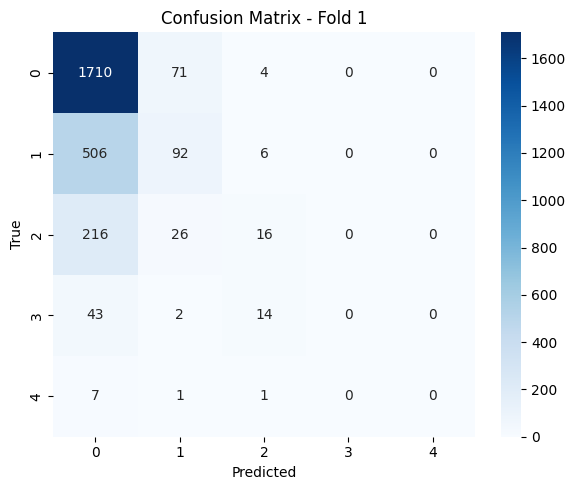

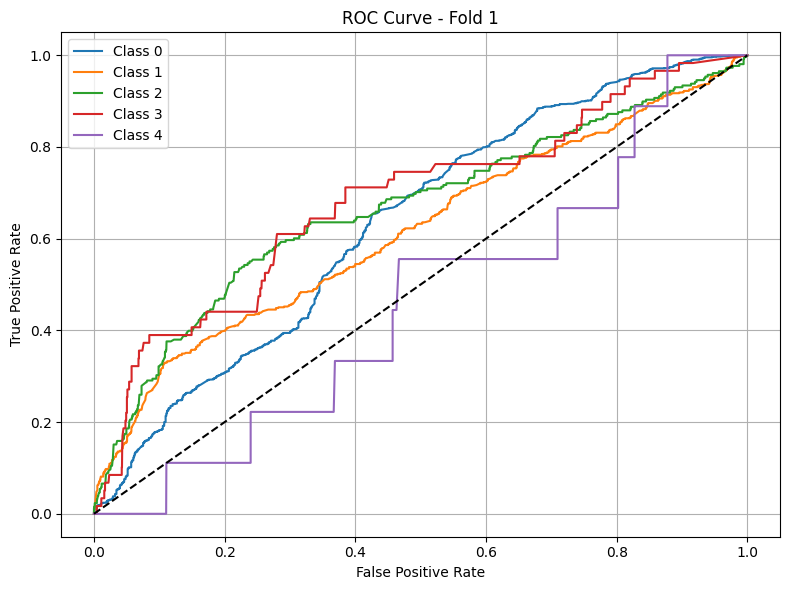

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.91      0.78      1786
           1       0.32      0.15      0.20       603
           2       0.29      0.05      0.09       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         8

    accuracy                           0.63      2714
   macro avg       0.26      0.22      0.21      2714
weighted avg       0.54      0.63      0.56      2714



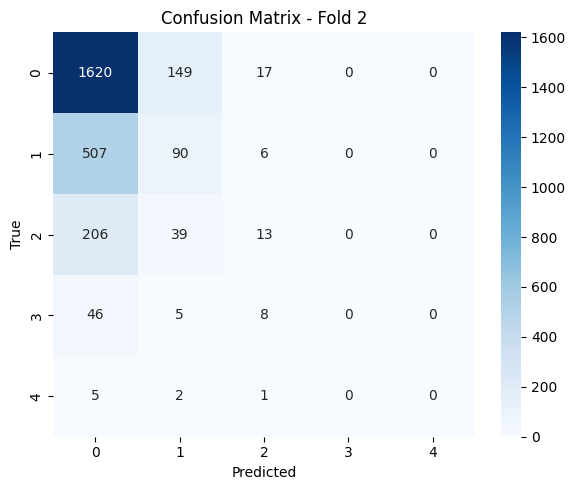

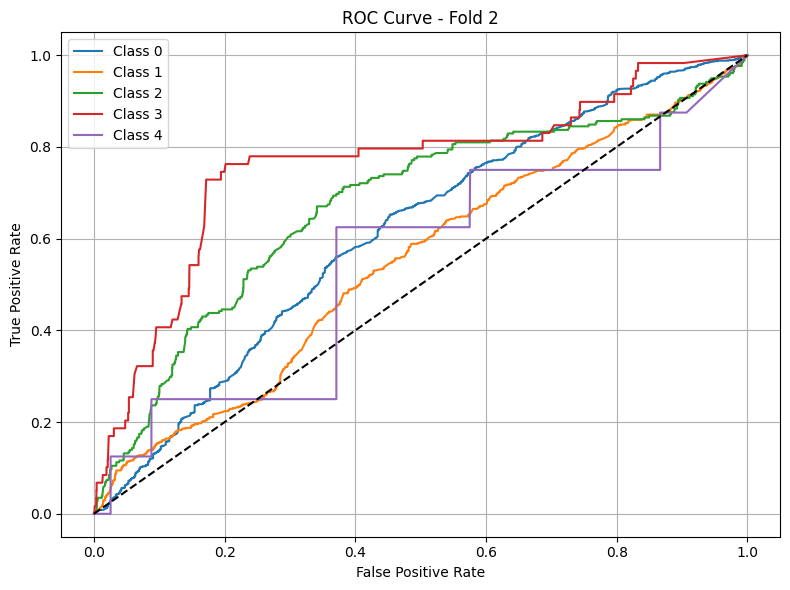


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.97      0.80      1786
           1       0.53      0.10      0.17       603
           2       0.86      0.02      0.05       258
           3       0.14      0.02      0.03        59
           4       0.00      0.00      0.00         8

    accuracy                           0.67      2714
   macro avg       0.44      0.22      0.21      2714
weighted avg       0.64      0.67      0.57      2714



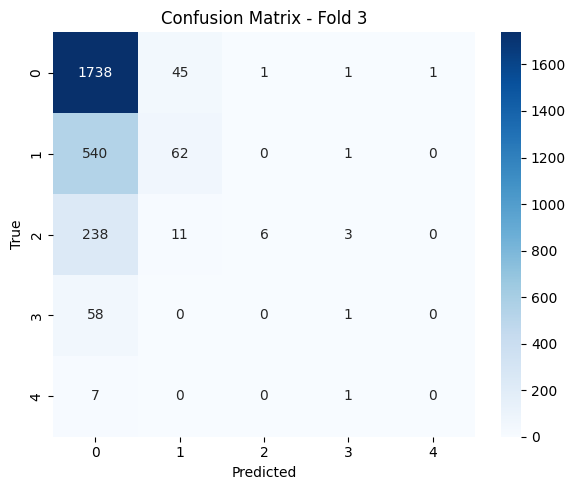

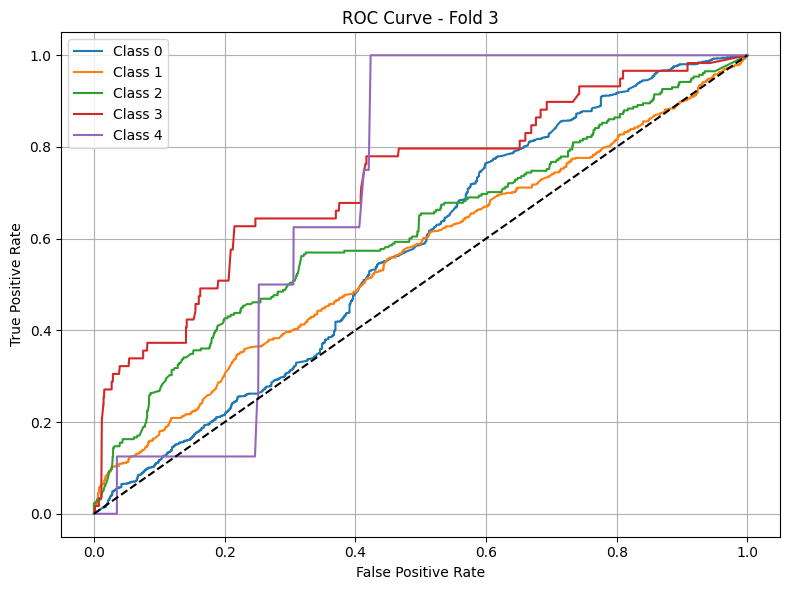

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.97      0.80      1785
           1       0.48      0.11      0.18       603
           2       0.50      0.08      0.13       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         9

    accuracy                           0.67      2714
   macro avg       0.33      0.23      0.22      2714
weighted avg       0.60      0.67      0.58      2714



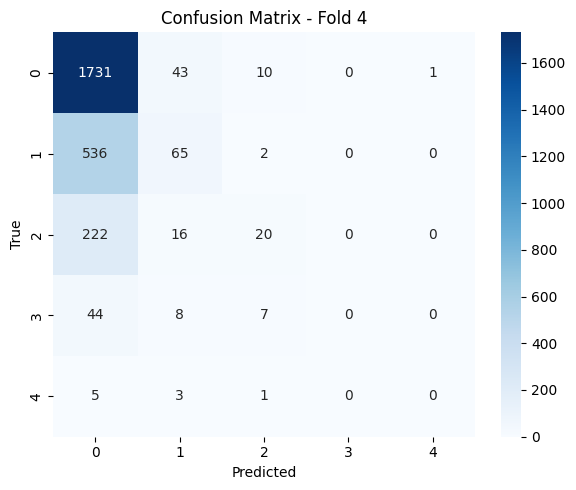

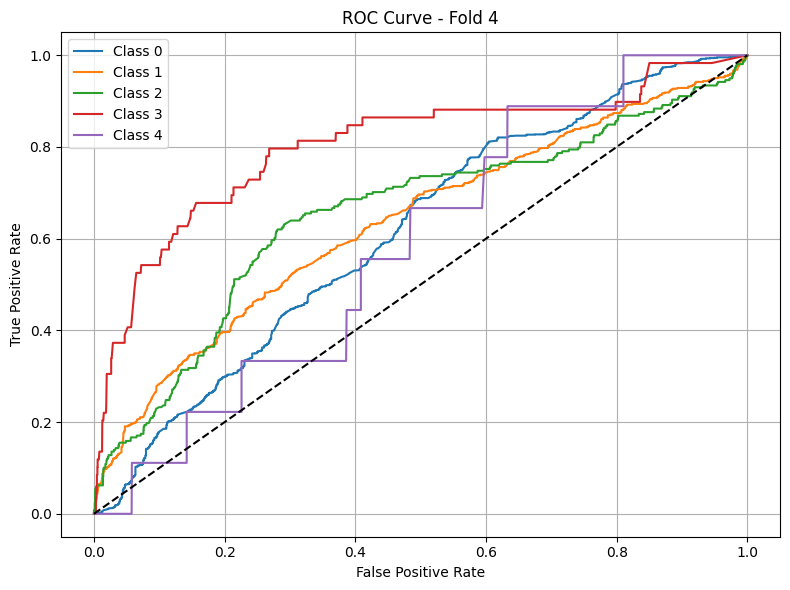

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.94      0.79      1785
           1       0.41      0.13      0.19       603
           2       0.29      0.10      0.14       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         9

    accuracy                           0.66      2714
   macro avg       0.28      0.23      0.23      2714
weighted avg       0.57      0.66      0.58      2714



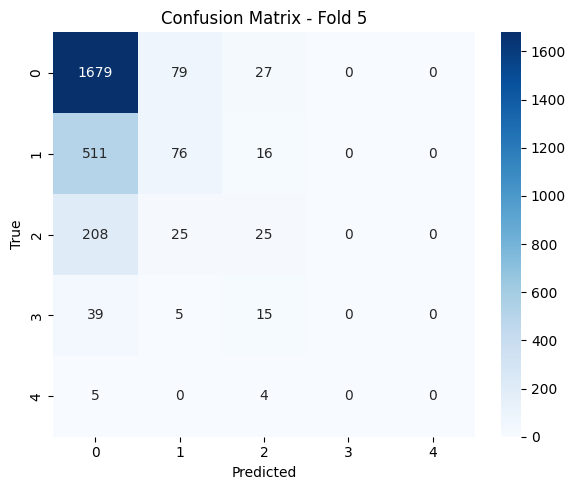

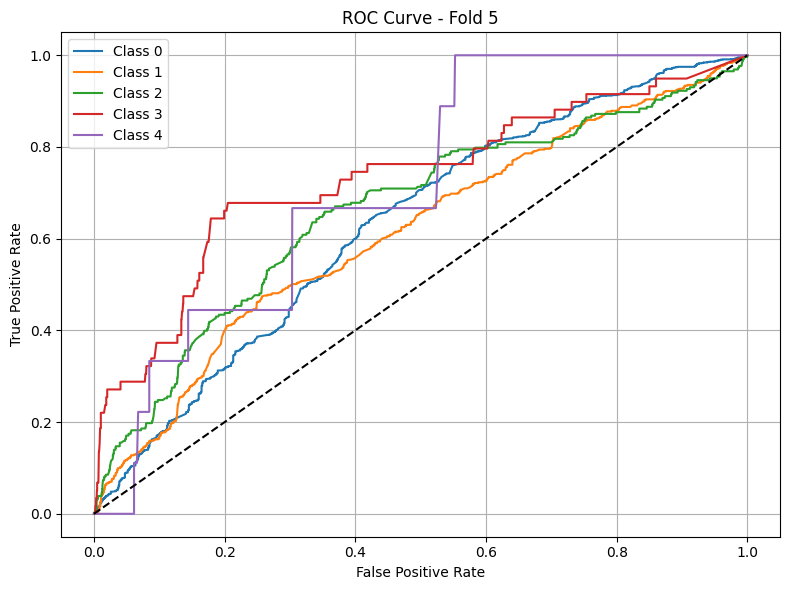


Average Accuracy: 0.6591
Average F1 Macro: 0.2197
Average AUC: 0.6412
{'phase1': [{'fold': 1, 'accuracy': 0.6696132596685083, 'f1_macro': 0.22793581461747286, 'auc': 0.6118918465850833}, {'fold': 2, 'accuracy': 0.6348563006632277, 'f1_macro': 0.2130979401653951, 'auc': 0.6280724239352257}, {'fold': 3, 'accuracy': 0.6658069270449521, 'f1_macro': 0.20870783578401575, 'auc': 0.6371881056855653}, {'fold': 4, 'accuracy': 0.6691230655858511, 'f1_macro': 0.2222425408936613, 'auc': 0.6581890796819108}, {'fold': 5, 'accuracy': 0.6558585114222549, 'f1_macro': 0.22644755626891624, 'auc': 0.6705979605718998}]}


======= Training Phase 2 ========



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.89      0.76      1489
           1       0.20      0.09      0.13       488
           2       0.24      0.04      0.07       220
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00         9

    accuracy                           0.61      2260
   macro avg       0.22      0.20      0.19      2260
weighted avg       0.50      0.61      0.54      2260



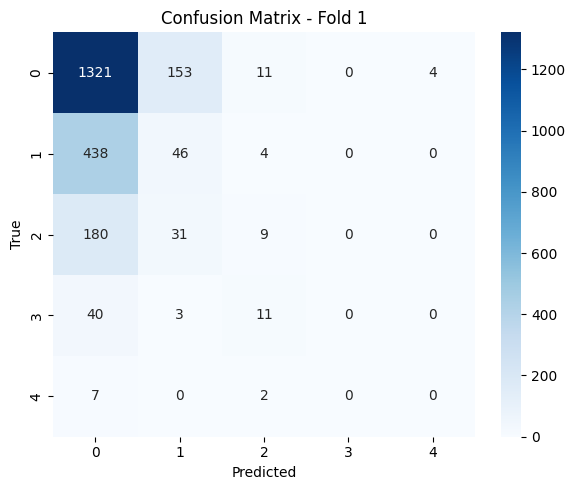

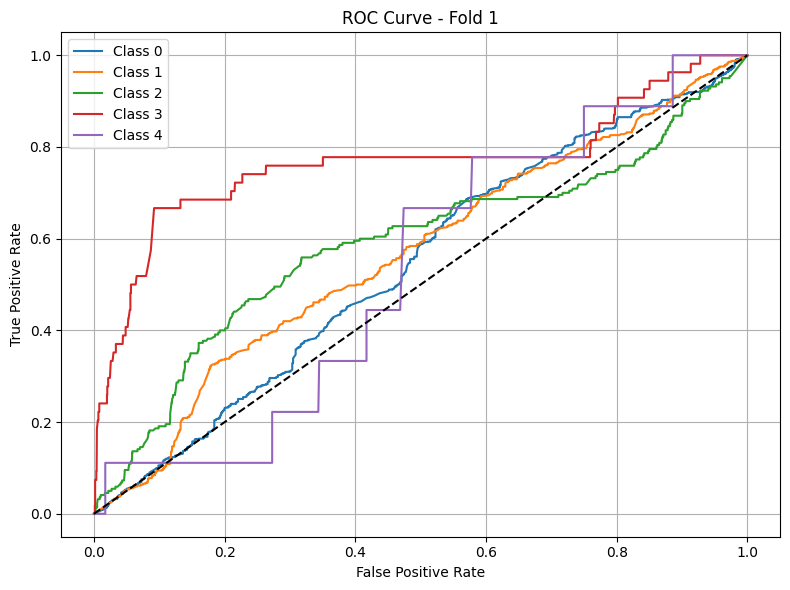

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.96      0.79      1489
           1       0.28      0.04      0.07       489
           2       0.46      0.07      0.13       219
           3       0.00      0.00      0.00        55
           4       0.00      0.00      0.00         8

    accuracy                           0.65      2260
   macro avg       0.28      0.22      0.20      2260
weighted avg       0.55      0.65      0.55      2260



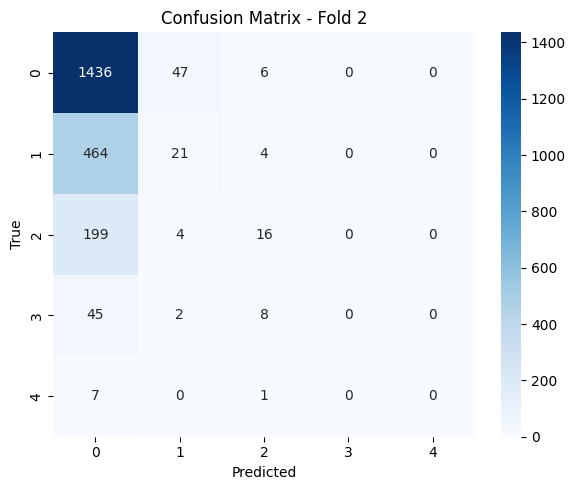

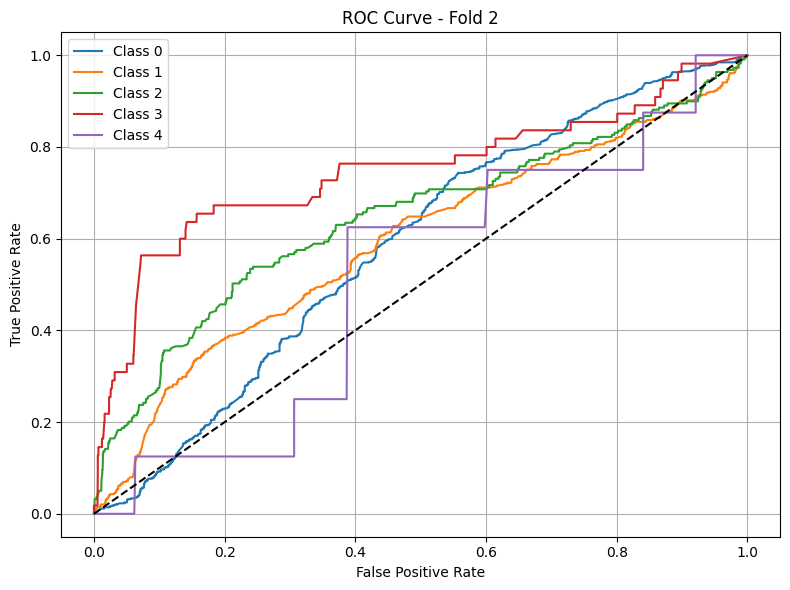

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.94      0.78      1489
           1       0.28      0.07      0.11       489
           2       0.20      0.05      0.07       219
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00         8

    accuracy                           0.64      2259
   macro avg       0.23      0.21      0.19      2259
weighted avg       0.52      0.64      0.55      2259



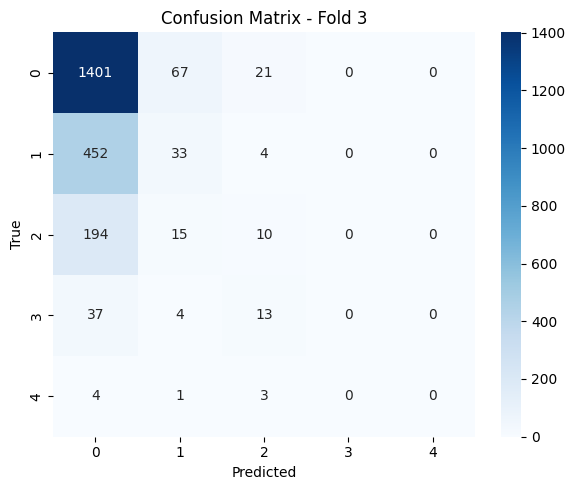

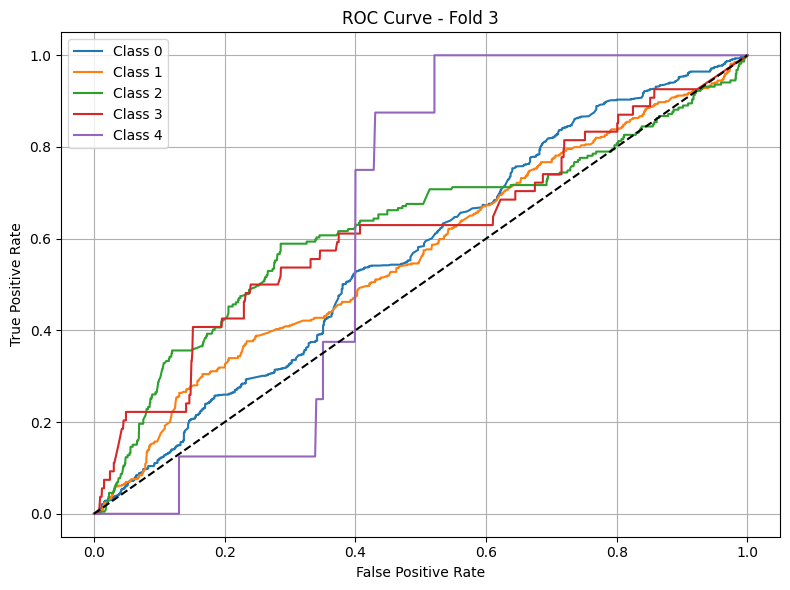


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.94      0.78      1489
           1       0.26      0.06      0.10       489
           2       0.19      0.03      0.05       219
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00         8

    accuracy                           0.64      2259
   macro avg       0.22      0.21      0.19      2259
weighted avg       0.52      0.64      0.54      2259



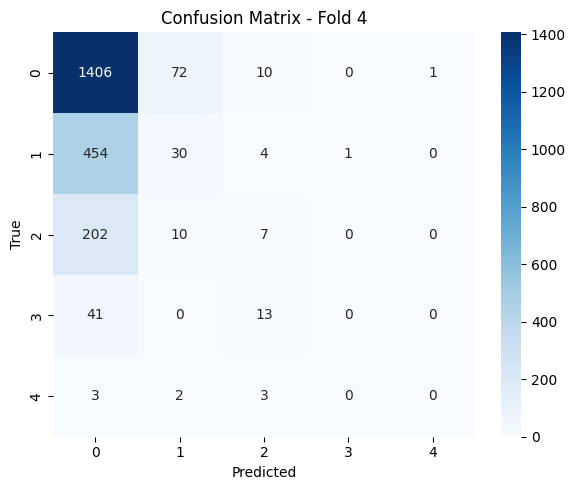

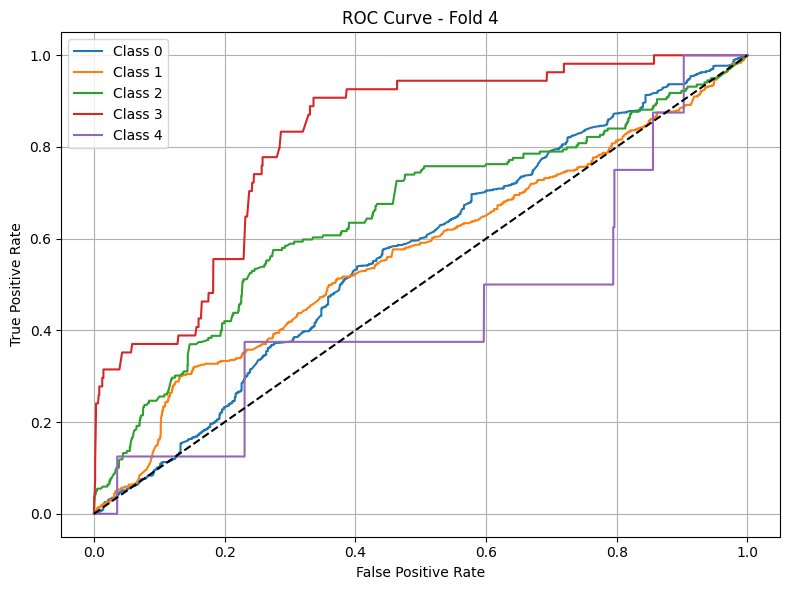


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.90      0.77      1490
           1       0.15      0.01      0.02       488
           2       0.12      0.07      0.09       219
           3       0.33      0.02      0.04        54
           4       0.00      0.00      0.00         8

    accuracy                           0.61      2259
   macro avg       0.25      0.20      0.18      2259
weighted avg       0.49      0.61      0.52      2259



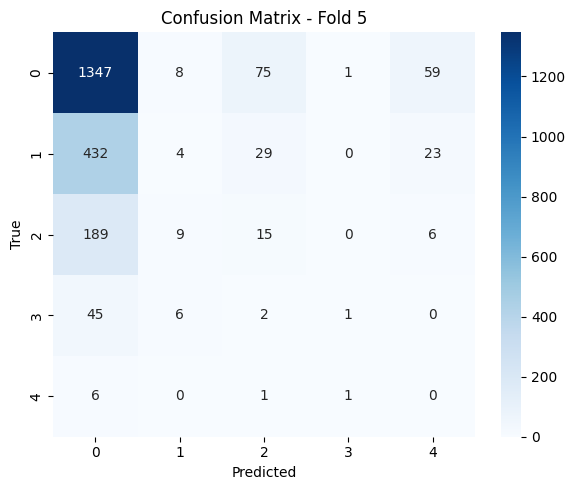

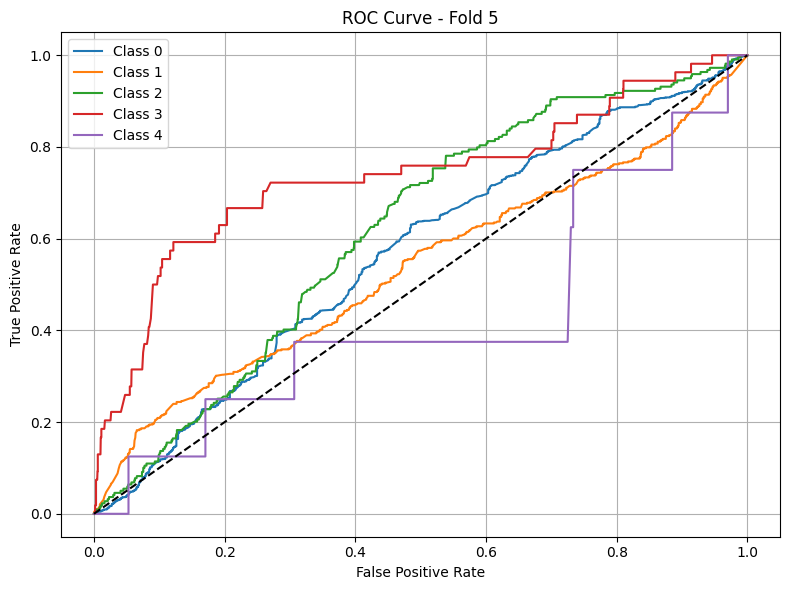


Average Accuracy: 0.6288
Average F1 Macro: 0.1902
Average AUC: 0.6002
{'phase1': [{'fold': 1, 'accuracy': 0.6696132596685083, 'f1_macro': 0.22793581461747286, 'auc': 0.6118918465850833}, {'fold': 2, 'accuracy': 0.6348563006632277, 'f1_macro': 0.2130979401653951, 'auc': 0.6280724239352257}, {'fold': 3, 'accuracy': 0.6658069270449521, 'f1_macro': 0.20870783578401575, 'auc': 0.6371881056855653}, {'fold': 4, 'accuracy': 0.6691230655858511, 'f1_macro': 0.2222425408936613, 'auc': 0.6581890796819108}, {'fold': 5, 'accuracy': 0.6558585114222549, 'f1_macro': 0.22644755626891624, 'auc': 0.6705979605718998}], 'phase2': [{'fold': 1, 'accuracy': 0.6088495575221239, 'f1_macro': 0.19158544701500602, 'auc': 0.5991920573677715}, {'fold': 2, 'accuracy': 0.6517699115044248, 'f1_macro': 0.197919119243856, 'auc': 0.6171609093596463}, {'fold': 3, 'accuracy': 0.6392208942009738, 'f1_macro': 0.19315729020837327, 'auc': 0.5996938940484436}, {'fold': 4, 'accuracy': 0.6387782204515272, 'f1_macro': 0.18727749681

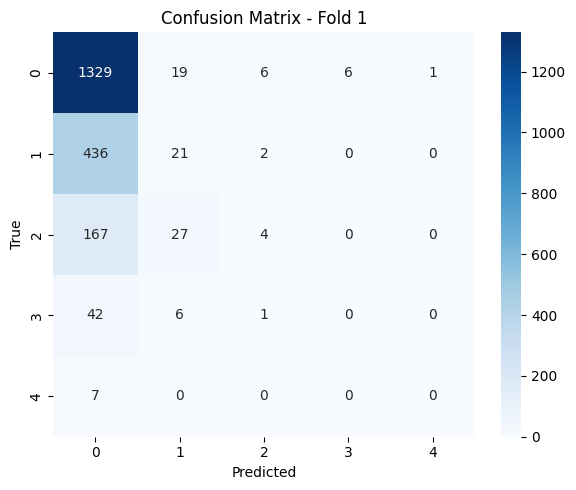

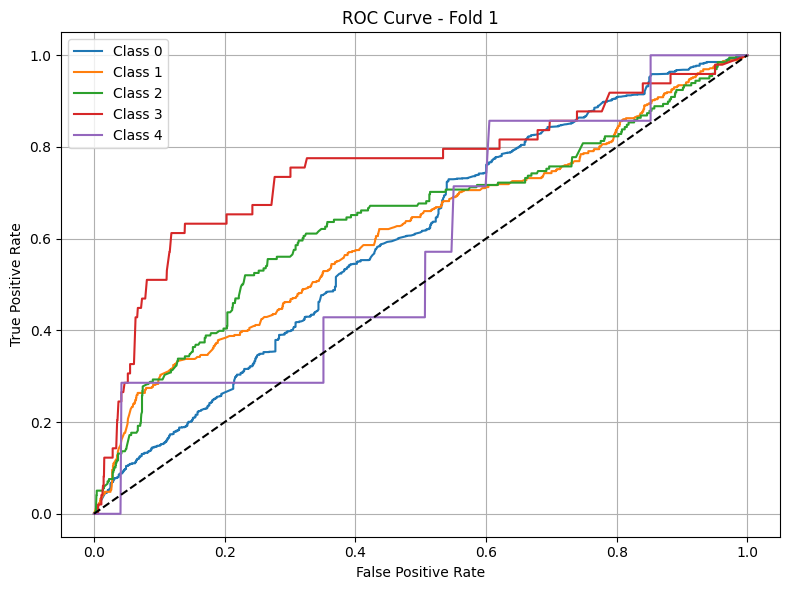


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.93      0.78      1360
           1       0.24      0.06      0.10       459
           2       0.13      0.05      0.07       198
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00         7

    accuracy                           0.63      2074
   macro avg       0.21      0.21      0.19      2074
weighted avg       0.51      0.63      0.54      2074



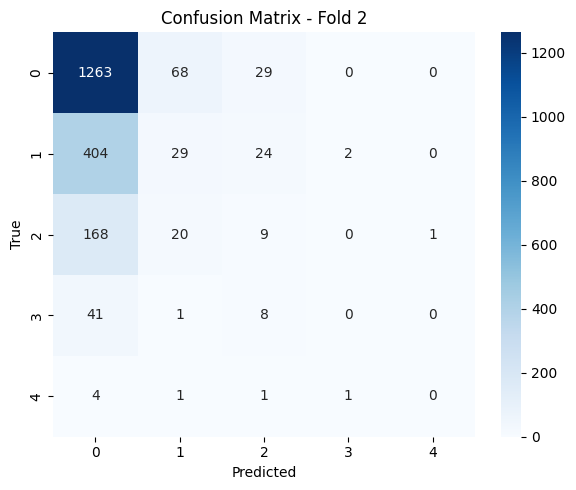

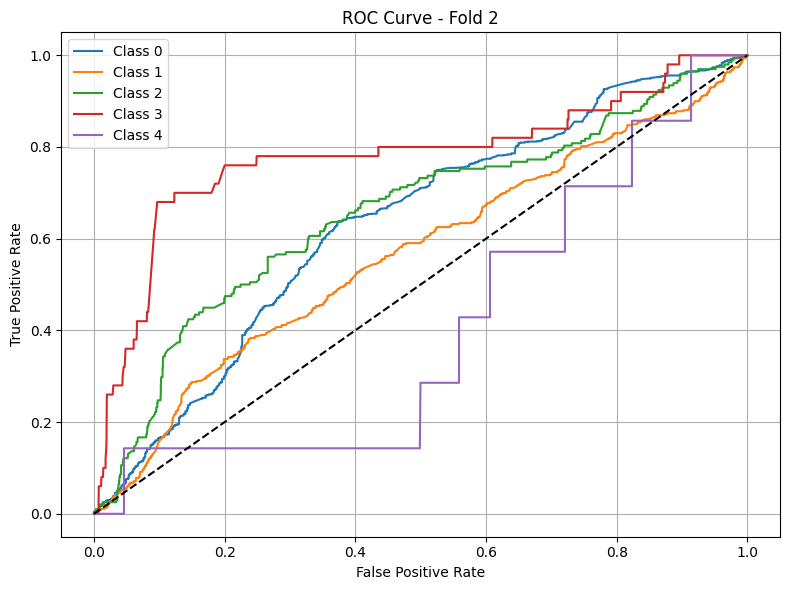

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.94      0.78      1360
           1       0.32      0.07      0.12       459
           2       0.27      0.09      0.13       198
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00         7

    accuracy                           0.64      2074
   macro avg       0.25      0.22      0.21      2074
weighted avg       0.54      0.64      0.55      2074



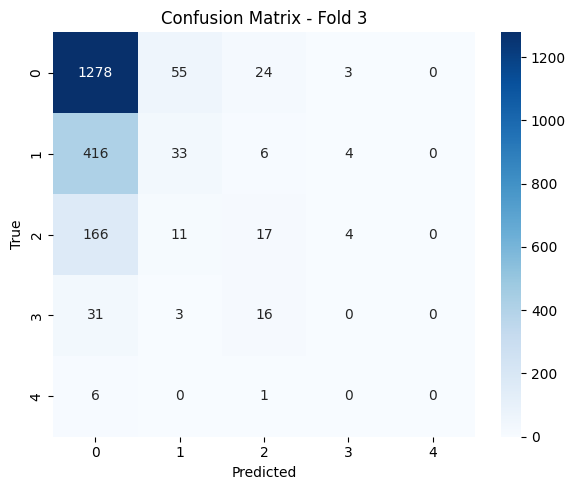

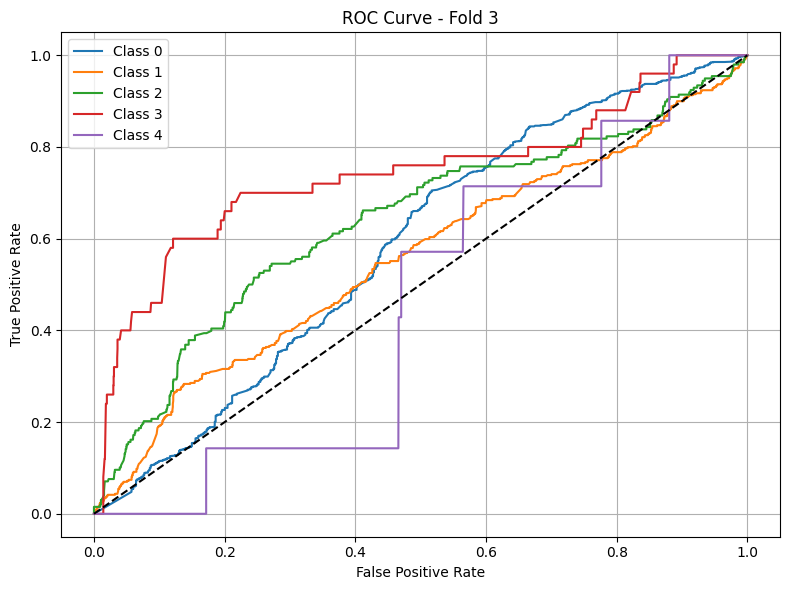

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.90      0.76      1360
           1       0.22      0.08      0.11       459
           2       0.10      0.03      0.05       198
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00         7

    accuracy                           0.61      2074
   macro avg       0.20      0.20      0.18      2074
weighted avg       0.49      0.61      0.53      2074



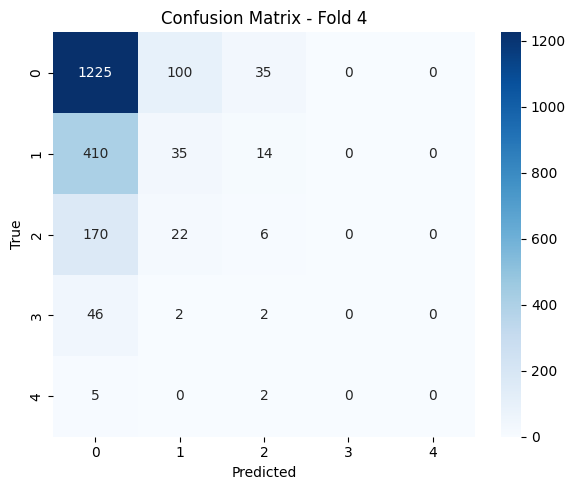

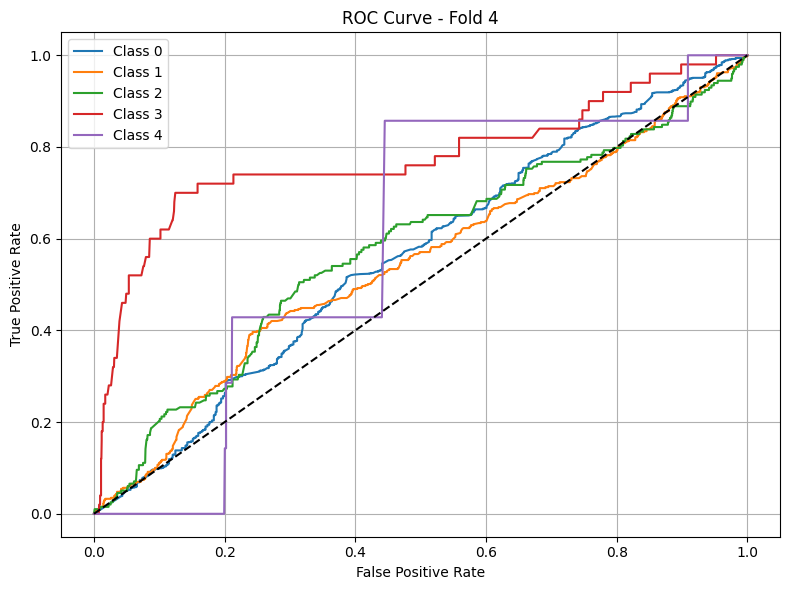


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.95      0.79      1360
           1       0.37      0.05      0.09       460
           2       0.37      0.11      0.17       197
           3       0.20      0.02      0.04        49
           4       0.00      0.00      0.00         7

    accuracy                           0.65      2073
   macro avg       0.32      0.23      0.22      2073
weighted avg       0.57      0.65      0.56      2073



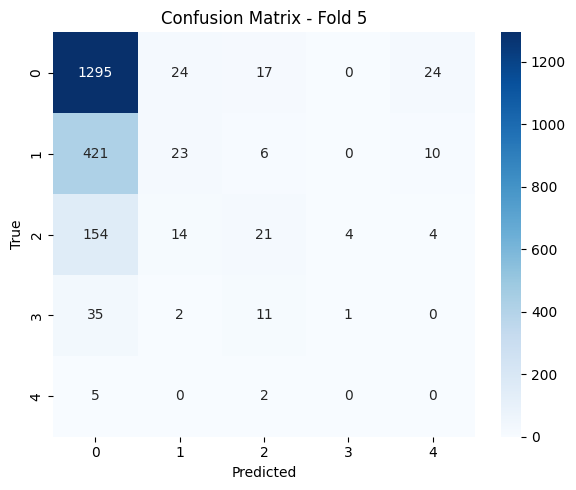

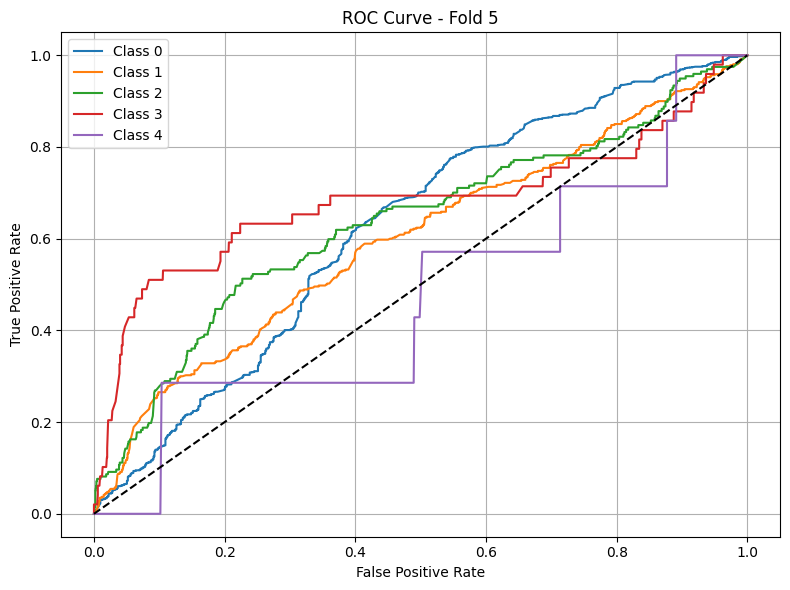


Average Accuracy: 0.6355
Average F1 Macro: 0.1958
Average AUC: 0.6106
{'phase1': [{'fold': 1, 'accuracy': 0.6696132596685083, 'f1_macro': 0.22793581461747286, 'auc': 0.6118918465850833}, {'fold': 2, 'accuracy': 0.6348563006632277, 'f1_macro': 0.2130979401653951, 'auc': 0.6280724239352257}, {'fold': 3, 'accuracy': 0.6658069270449521, 'f1_macro': 0.20870783578401575, 'auc': 0.6371881056855653}, {'fold': 4, 'accuracy': 0.6691230655858511, 'f1_macro': 0.2222425408936613, 'auc': 0.6581890796819108}, {'fold': 5, 'accuracy': 0.6558585114222549, 'f1_macro': 0.22644755626891624, 'auc': 0.6705979605718998}], 'phase2': [{'fold': 1, 'accuracy': 0.6088495575221239, 'f1_macro': 0.19158544701500602, 'auc': 0.5991920573677715}, {'fold': 2, 'accuracy': 0.6517699115044248, 'f1_macro': 0.197919119243856, 'auc': 0.6171609093596463}, {'fold': 3, 'accuracy': 0.6392208942009738, 'f1_macro': 0.19315729020837327, 'auc': 0.5996938940484436}, {'fold': 4, 'accuracy': 0.6387782204515272, 'f1_macro': 0.18727749681

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.93      0.77      1000
           1       0.40      0.14      0.21       355
           2       0.04      0.01      0.01       139
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00         6

    accuracy                           0.63      1539
   macro avg       0.22      0.21      0.20      1539
weighted avg       0.53      0.63      0.55      1539



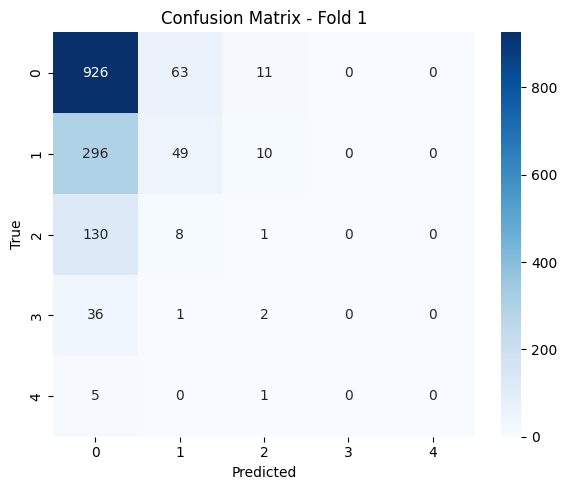

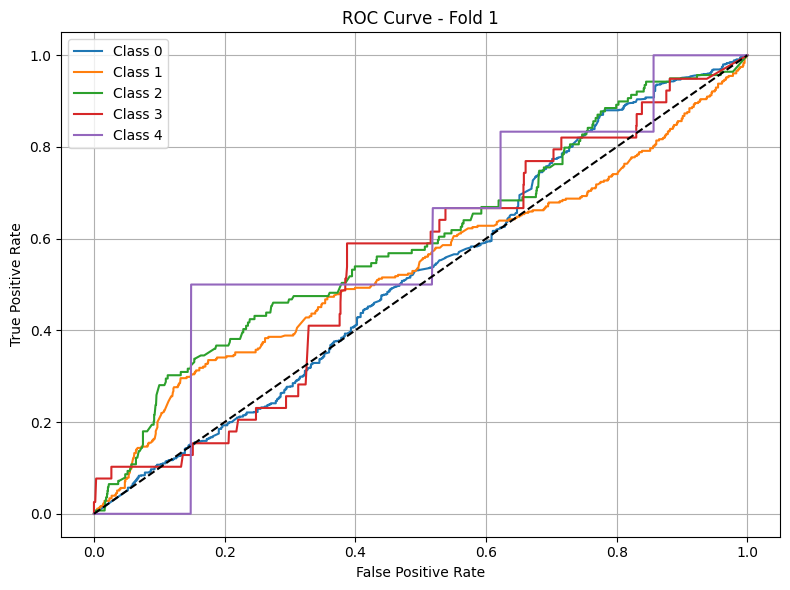

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79      1000
           1       0.56      0.14      0.22       355
           2       0.75      0.02      0.04       139
           3       0.67      0.05      0.09        40
           4       0.00      0.00      0.00         5

    accuracy                           0.66      1539
   macro avg       0.53      0.23      0.23      1539
weighted avg       0.65      0.66      0.57      1539



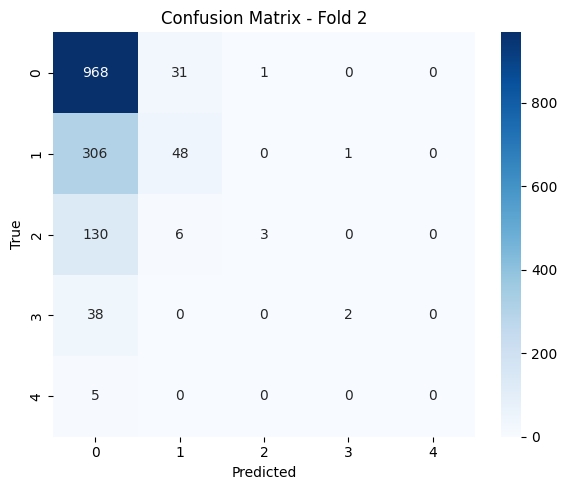

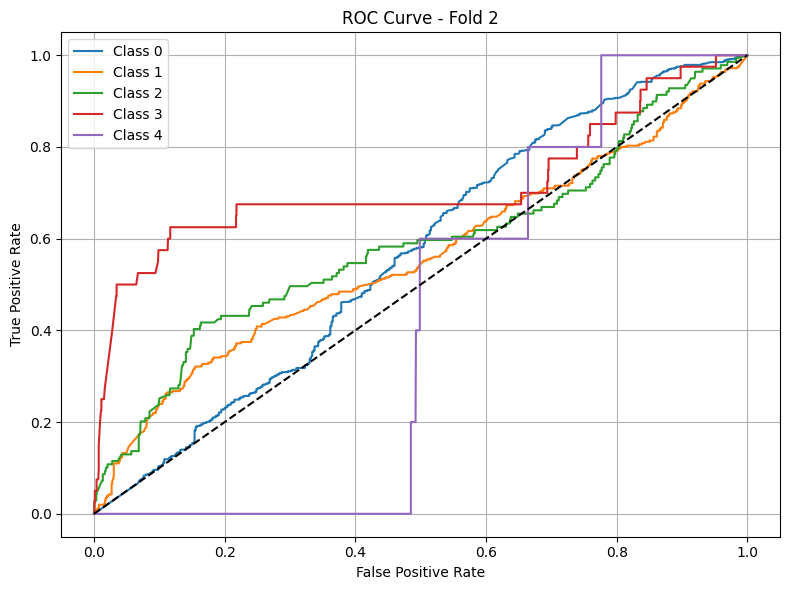

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.85      0.76       999
           1       0.41      0.26      0.32       355
           2       0.24      0.14      0.18       139
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00         6

    accuracy                           0.63      1539
   macro avg       0.27      0.25      0.25      1539
weighted avg       0.57      0.63      0.59      1539



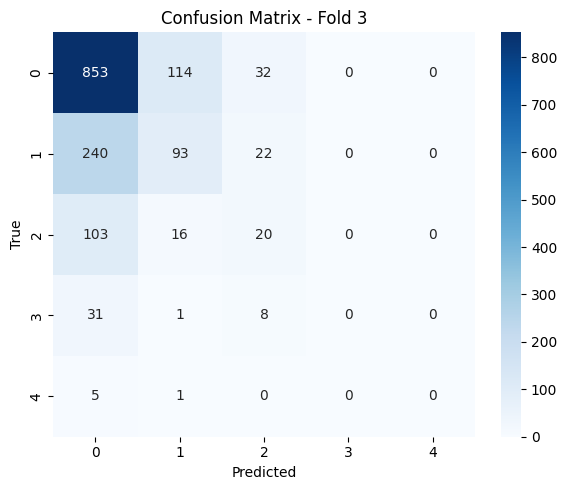

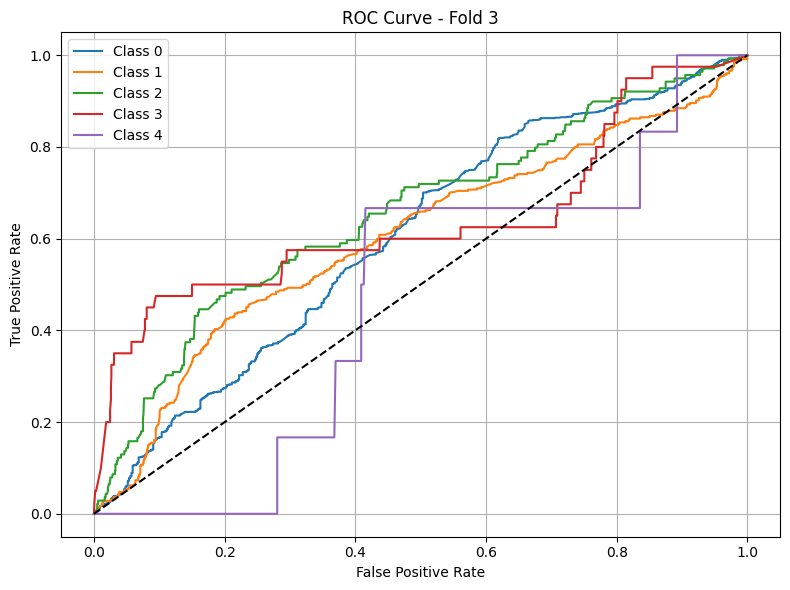


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.93      0.78       999
           1       0.43      0.12      0.19       356
           2       0.20      0.04      0.06       138
           3       0.06      0.05      0.05        39
           4       0.00      0.00      0.00         6

    accuracy                           0.64      1538
   macro avg       0.27      0.23      0.22      1538
weighted avg       0.56      0.64      0.56      1538



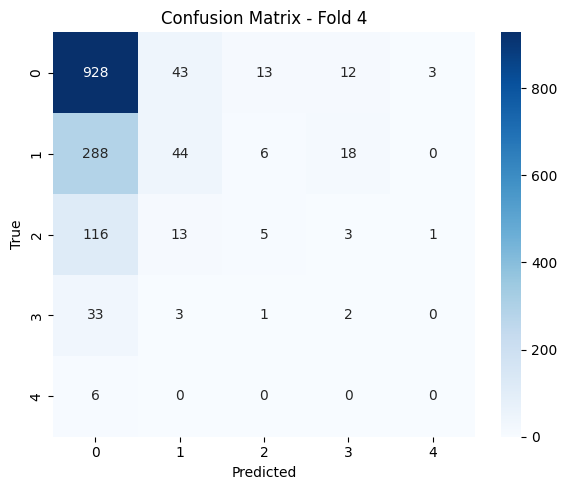

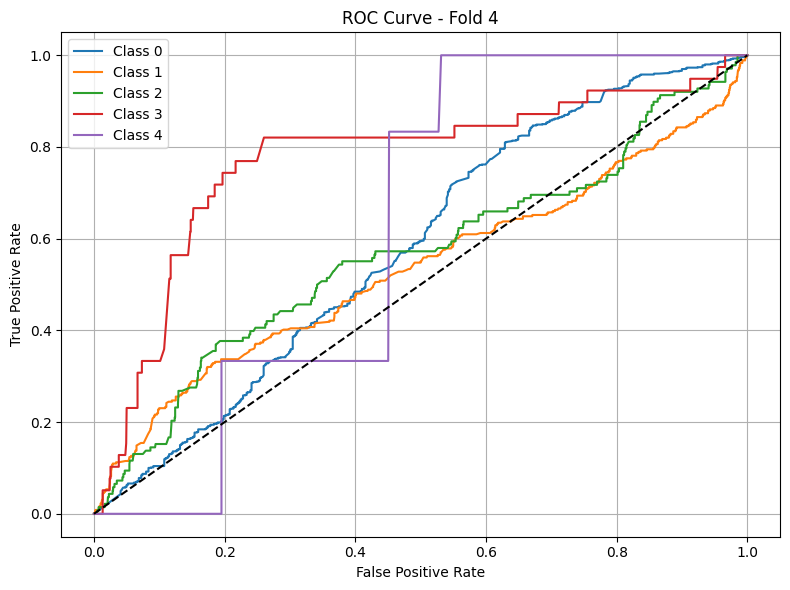


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.76      0.72       999
           1       0.35      0.24      0.28       356
           2       0.32      0.05      0.09       138
           3       0.00      0.00      0.00        39
           4       0.02      0.33      0.03         6

    accuracy                           0.55      1538
   macro avg       0.27      0.28      0.22      1538
weighted avg       0.55      0.55      0.54      1538



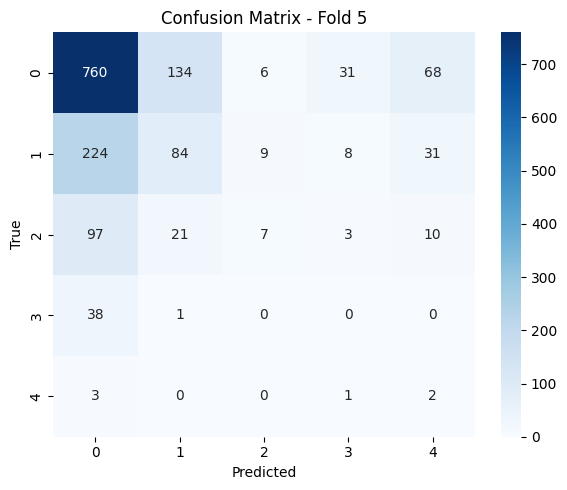

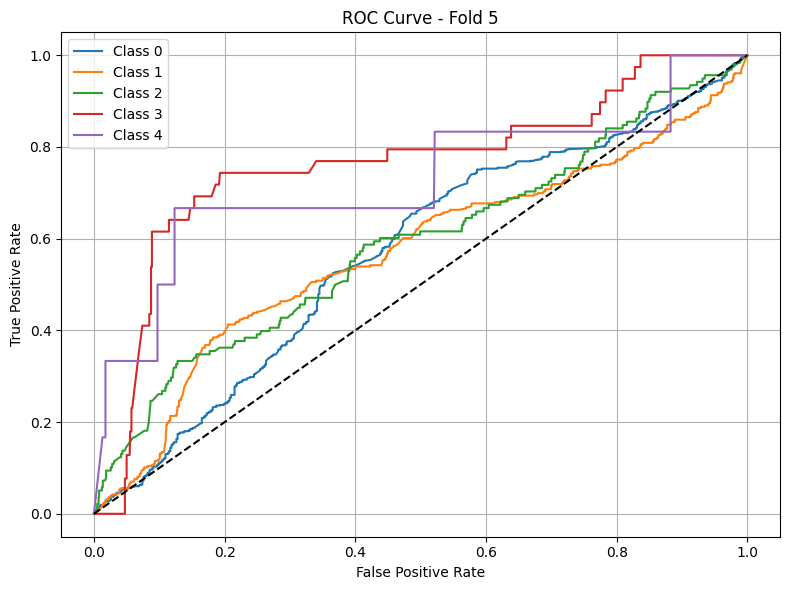


Average Accuracy: 0.6233
Average F1 Macro: 0.2245
Average AUC: 0.5957
{'phase1': [{'fold': 1, 'accuracy': 0.6696132596685083, 'f1_macro': 0.22793581461747286, 'auc': 0.6118918465850833}, {'fold': 2, 'accuracy': 0.6348563006632277, 'f1_macro': 0.2130979401653951, 'auc': 0.6280724239352257}, {'fold': 3, 'accuracy': 0.6658069270449521, 'f1_macro': 0.20870783578401575, 'auc': 0.6371881056855653}, {'fold': 4, 'accuracy': 0.6691230655858511, 'f1_macro': 0.2222425408936613, 'auc': 0.6581890796819108}, {'fold': 5, 'accuracy': 0.6558585114222549, 'f1_macro': 0.22644755626891624, 'auc': 0.6705979605718998}], 'phase2': [{'fold': 1, 'accuracy': 0.6088495575221239, 'f1_macro': 0.19158544701500602, 'auc': 0.5991920573677715}, {'fold': 2, 'accuracy': 0.6517699115044248, 'f1_macro': 0.197919119243856, 'auc': 0.6171609093596463}, {'fold': 3, 'accuracy': 0.6392208942009738, 'f1_macro': 0.19315729020837327, 'auc': 0.5996938940484436}, {'fold': 4, 'accuracy': 0.6387782204515272, 'f1_macro': 0.18727749681

In [7]:
import torch

phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")

    sample = False
    # Save best model state_dict and scaler
    sample_tag = "sample" if sample else "no_sample"
    best_model_state, best_scaler, best_label_encoder, metrics = train_phase(phase_path, sample=sample)
    torch.save(best_model_state, f"best_model_state_{sample_tag}_phase{i}.pt")
    joblib.dump(best_scaler, f"best_scaler_{sample_tag}_phase{i}.pkl")
    joblib.dump(best_label_encoder, f"label_encoder_{sample_tag}_phase{i}.pkl")

    results[f"phase{i}"] = metrics
    print(results)



Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       568
           1       0.27      0.49      0.35        63
           2       0.20      0.02      0.04        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.79       698
   macro avg       0.27      0.28      0.26       698
weighted avg       0.76      0.79      0.77       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


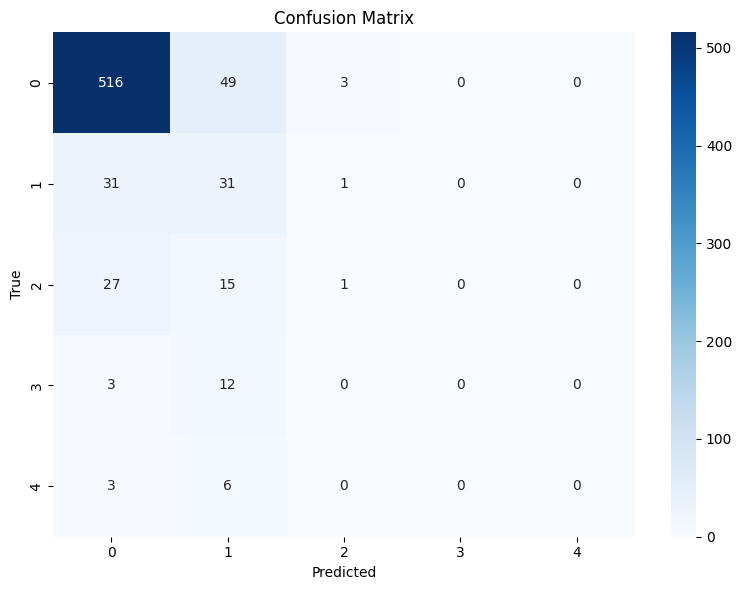


Test AUC (macro-average, OVR): 0.5625


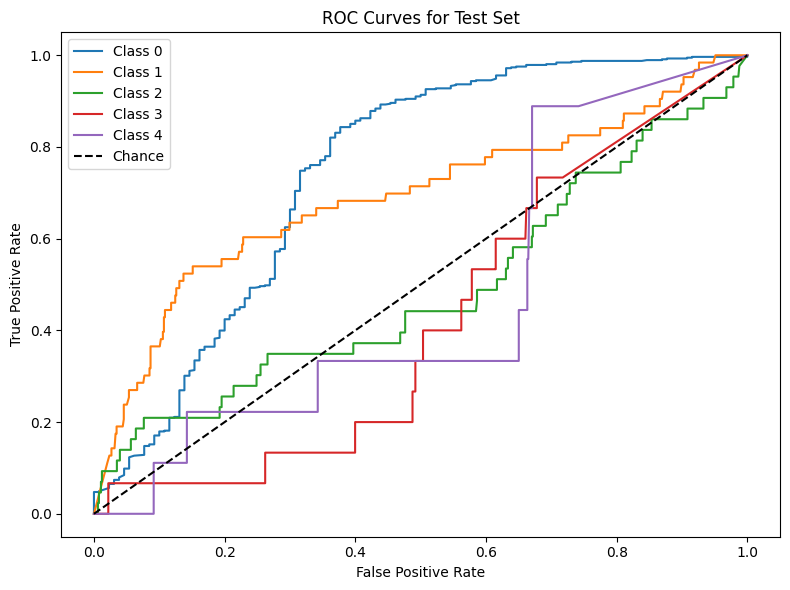


Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       544
           1       0.10      0.05      0.07        59
           2       0.25      0.02      0.04        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.78       668
   macro avg       0.23      0.20      0.20       668
weighted avg       0.69      0.78      0.72       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


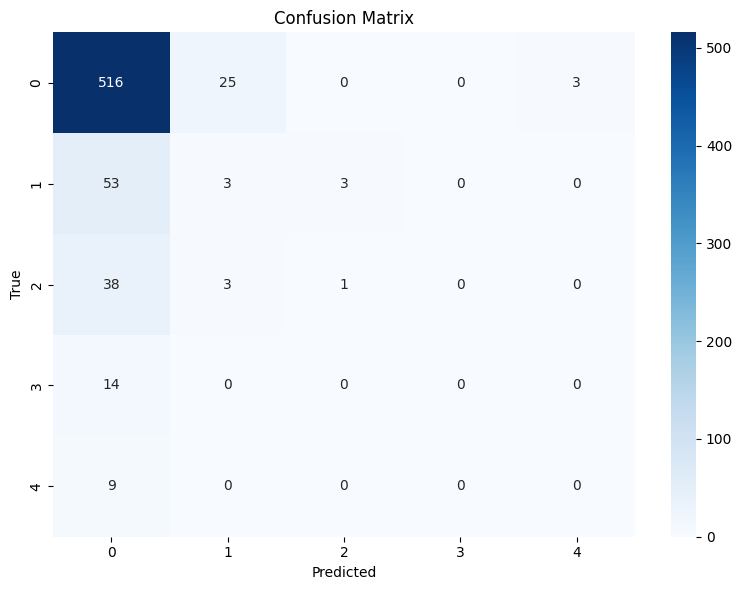


Test AUC (macro-average, OVR): 0.3651


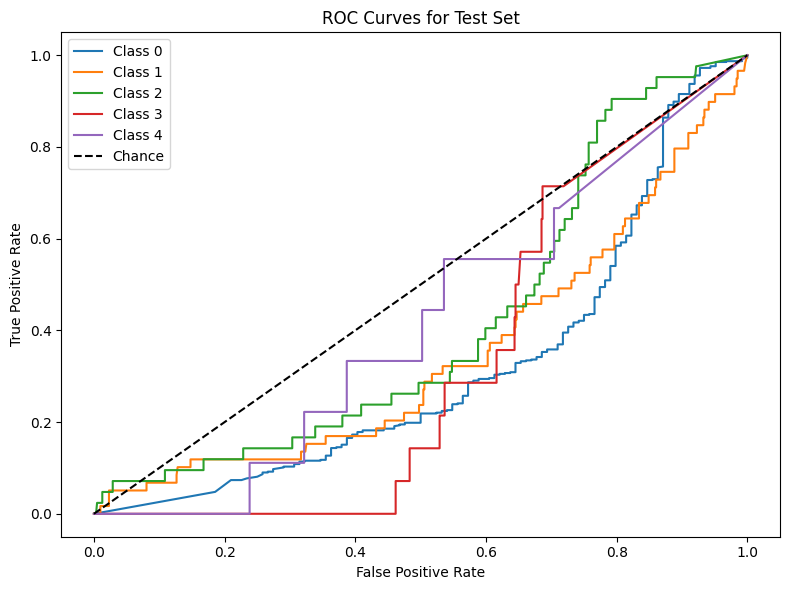


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       455
           1       0.07      0.10      0.08        52
           2       0.20      0.03      0.06        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.70       554
   macro avg       0.22      0.19      0.20       554
weighted avg       0.72      0.70      0.70       554



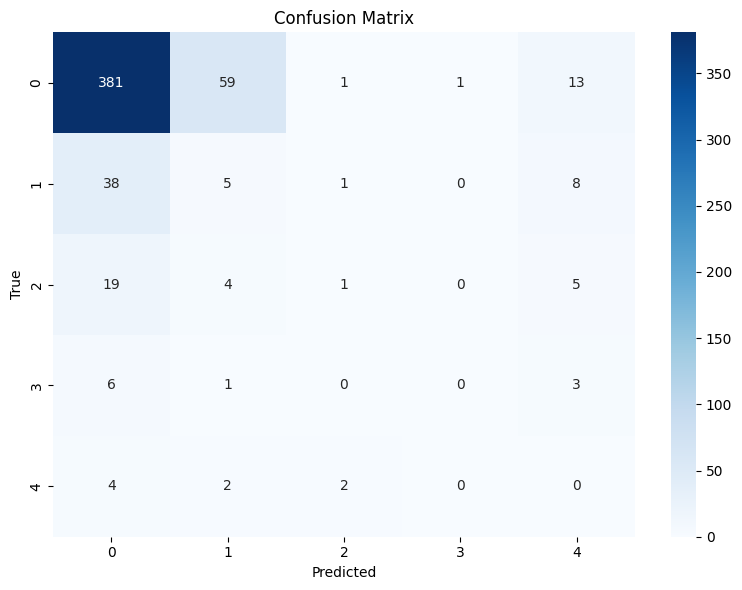


Test AUC (macro-average, OVR): 0.4565


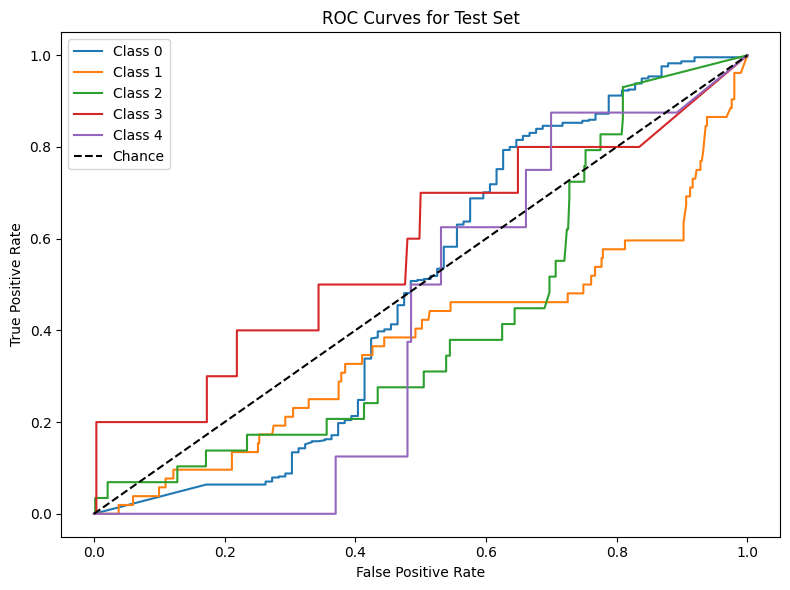


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.38      0.54       395
           1       0.06      0.35      0.10        40
           2       0.11      0.33      0.17        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.36       477
   macro avg       0.21      0.21      0.16       477
weighted avg       0.74      0.36      0.46       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


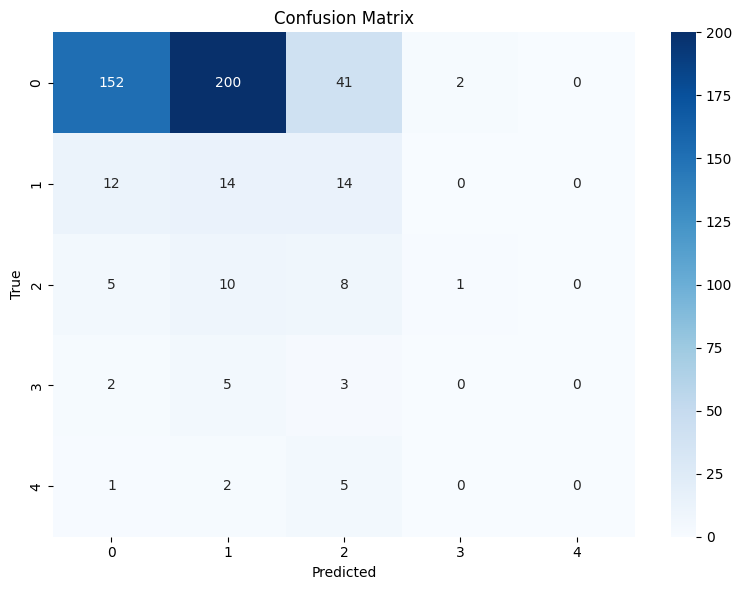


Test AUC (macro-average, OVR): 0.4390


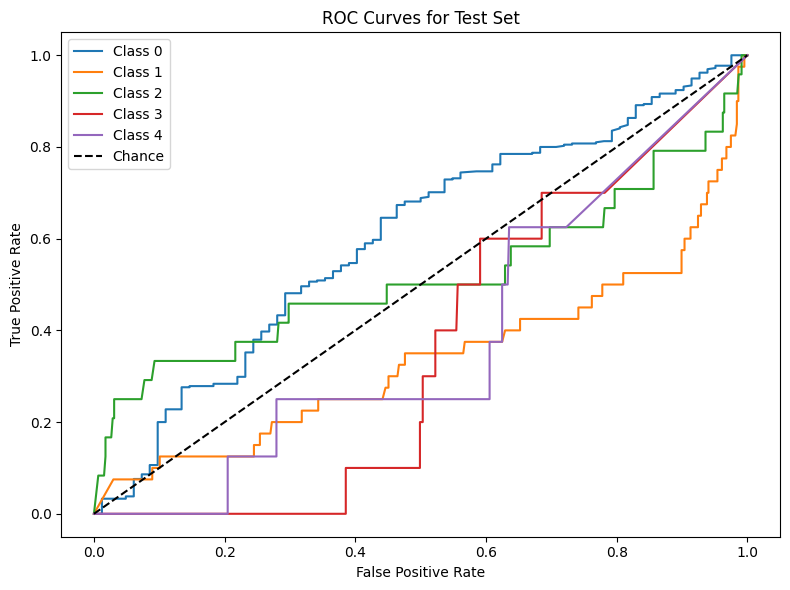

In [8]:
for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_state_{sample_tag}_phase{i}.pt'
    scaler_path = f'/kaggle/working/best_scaler_{sample_tag}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'
    
    label_encoder_dir = f"/kaggle/working/label_encoder_{sample_tag}_phase{i}.pkl"

    # Predict on test set
    y_preds = evaluate_gnn_on_test(
        test_file_path = test_dir,
        model_class=GATModel,
        model_state_dict=model_path,
        scaler_file=scaler_path,
        label_encoder_file = label_encoder_dir,
        school_mapping_file=school_mapping_file,
        k=5
    )


# Sample Data



======= Training Phase 1 ========


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.52      0.63      1785
           1       0.33      0.41      0.36       604
           2       0.18      0.22      0.20       258
           3       0.11      0.59      0.18        59
           4       0.03      0.33      0.05         9

    accuracy                           0.47      2715
   macro avg       0.28      0.42      0.28      2715
weighted avg       0.60      0.47      0.52      2715



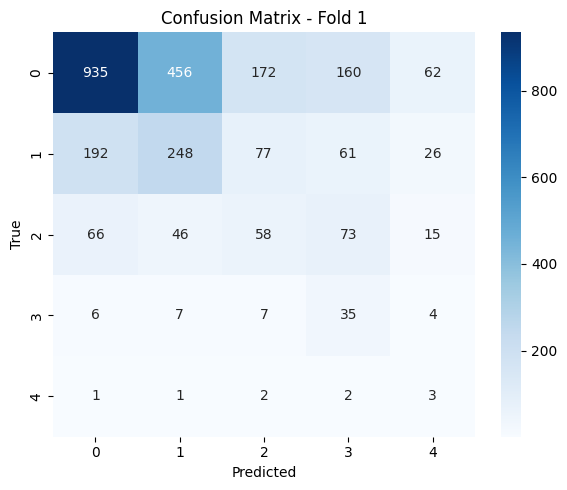

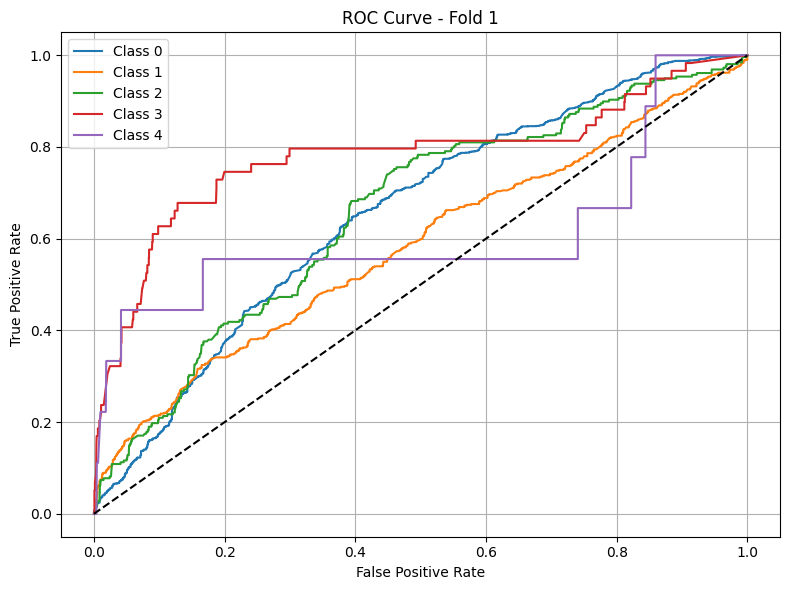


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.43      0.55      1786
           1       0.31      0.40      0.35       603
           2       0.15      0.26      0.19       258
           3       0.14      0.75      0.24        59
           4       0.02      0.50      0.05         8

    accuracy                           0.42      2714
   macro avg       0.28      0.47      0.28      2714
weighted avg       0.59      0.42      0.47      2714



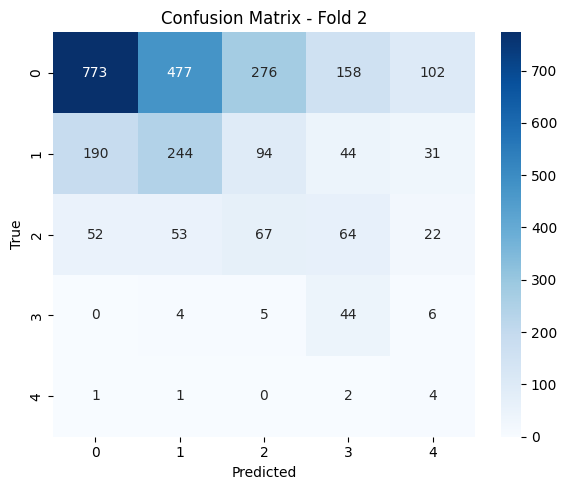

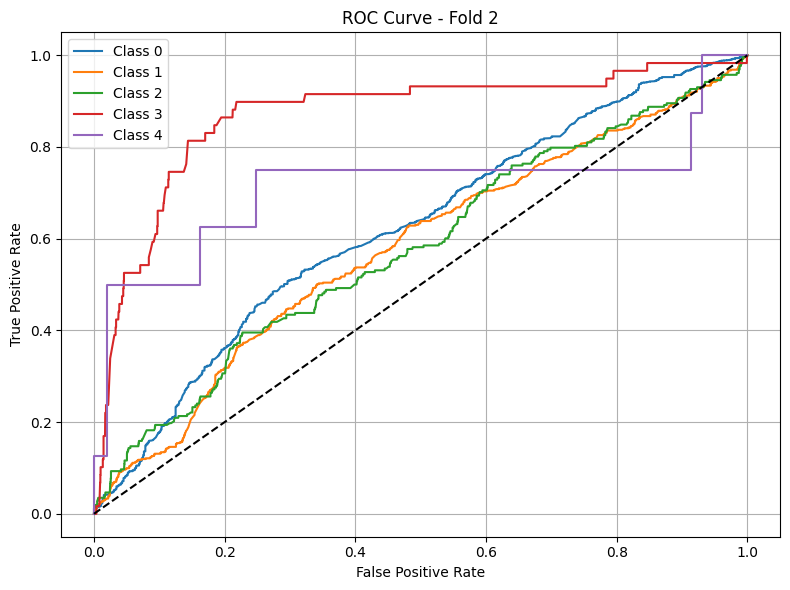


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.36      0.49      1786
           1       0.30      0.39      0.34       603
           2       0.17      0.38      0.24       258
           3       0.12      0.61      0.21        59
           4       0.02      0.62      0.05         8

    accuracy                           0.37      2714
   macro avg       0.27      0.47      0.26      2714
weighted avg       0.58      0.37      0.42      2714



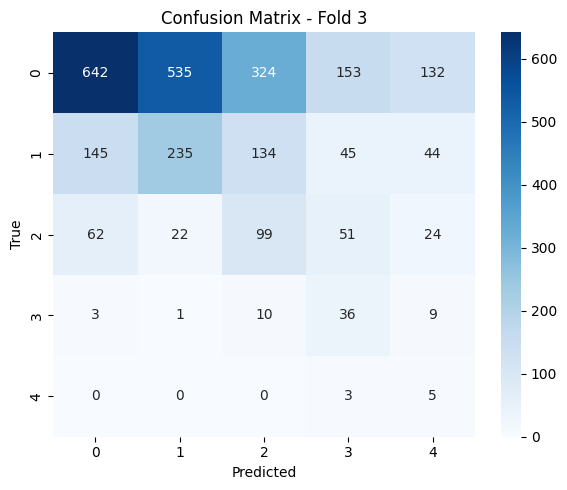

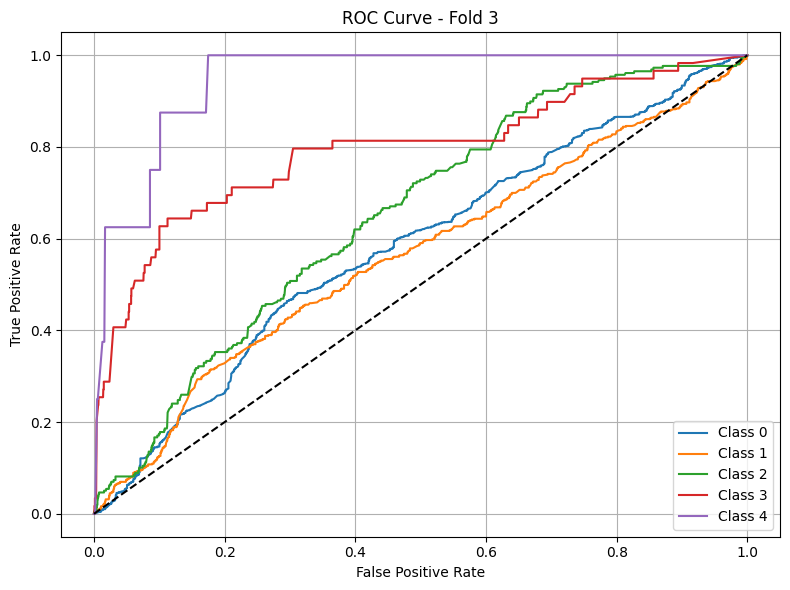


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.42      0.54      1785
           1       0.31      0.42      0.36       603
           2       0.16      0.27      0.20       258
           3       0.09      0.59      0.16        59
           4       0.06      0.44      0.10         9

    accuracy                           0.41      2714
   macro avg       0.27      0.43      0.27      2714
weighted avg       0.58      0.41      0.46      2714



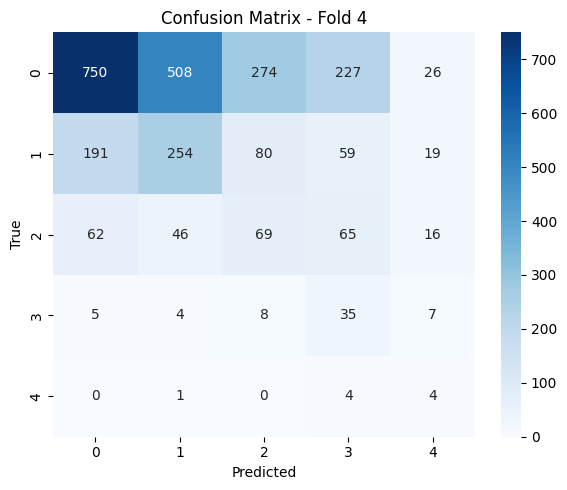

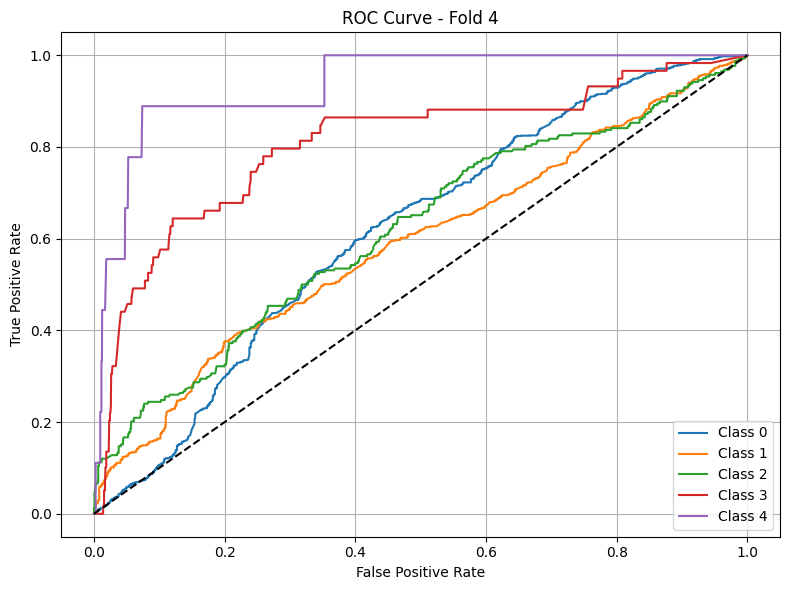


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.50      0.59      1785
           1       0.31      0.30      0.30       603
           2       0.18      0.28      0.22       258
           3       0.11      0.66      0.18        59
           4       0.05      0.78      0.09         9

    accuracy                           0.44      2714
   macro avg       0.27      0.50      0.28      2714
weighted avg       0.57      0.44      0.48      2714



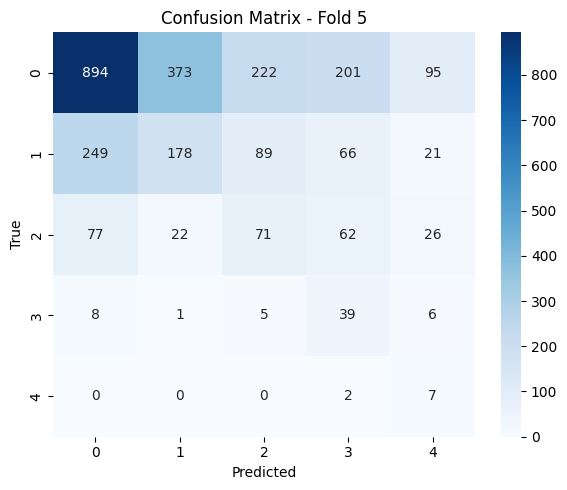

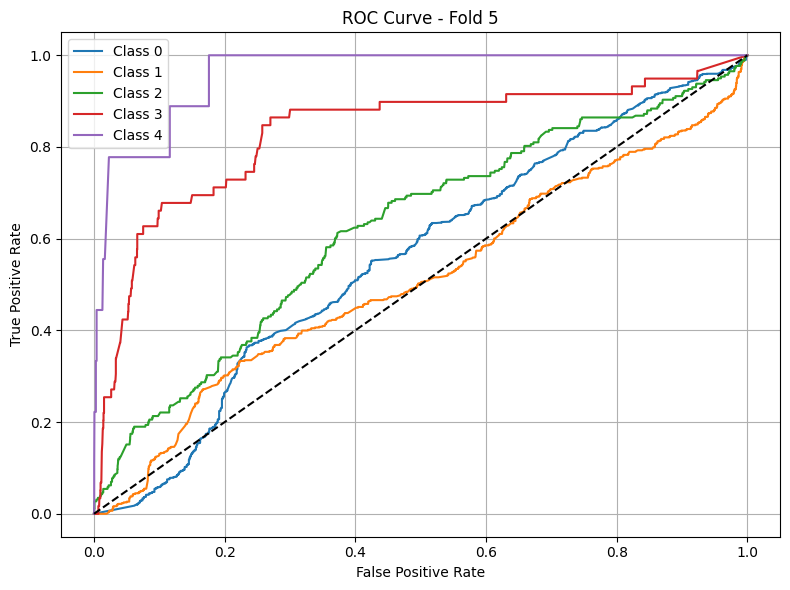


Average Accuracy: 0.4221
Average F1 Macro: 0.2741
Average AUC: 0.6895
{'phase1': [{'fold': 1, 'accuracy': 0.47108655616942907, 'f1_macro': 0.28452678785381236, 'auc': 0.6573029871503392}, {'fold': 2, 'accuracy': 0.4170965364775239, 'f1_macro': 0.27594565901842805, 'auc': 0.6714548053961716}, {'fold': 3, 'accuracy': 0.3747236551215917, 'f1_macro': 0.2631892862417986, 'auc': 0.7088493780102354}, {'fold': 4, 'accuracy': 0.4097273397199705, 'f1_macro': 0.2701543404992693, 'auc': 0.7132880151629672}, {'fold': 5, 'accuracy': 0.43809874723655123, 'f1_macro': 0.27664628841734806, 'auc': 0.6964477490851373}]}


======= Training Phase 2 ========


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.49      0.59      1489
           1       0.31      0.32      0.31       488
           2       0.16      0.31      0.21       220
           3       0.13      0.65      0.21        54
           4       0.05      0.56      0.09        

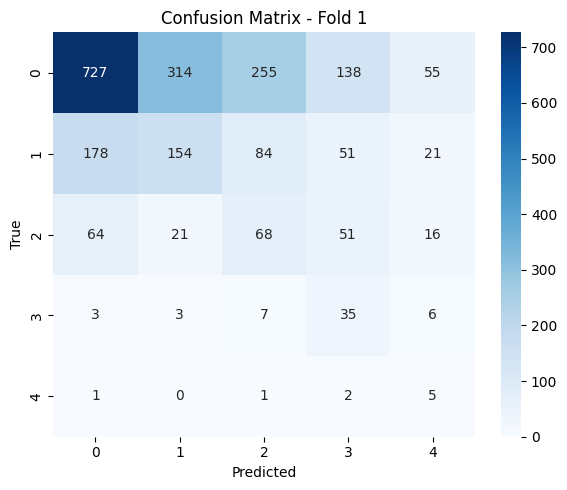

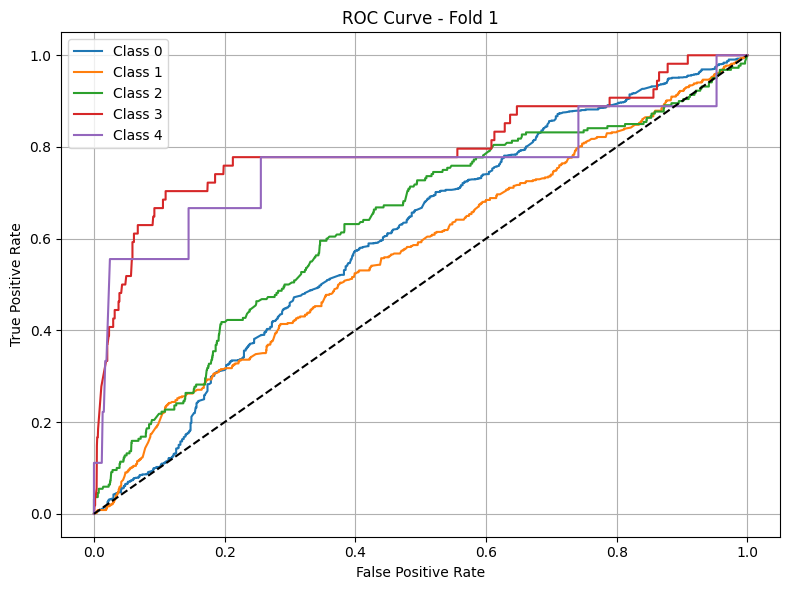


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.50      0.61      1489
           1       0.32      0.40      0.35       489
           2       0.14      0.26      0.18       219
           3       0.16      0.60      0.25        55
           4       0.05      0.62      0.10         8

    accuracy                           0.45      2260
   macro avg       0.29      0.48      0.30      2260
weighted avg       0.60      0.45      0.50      2260



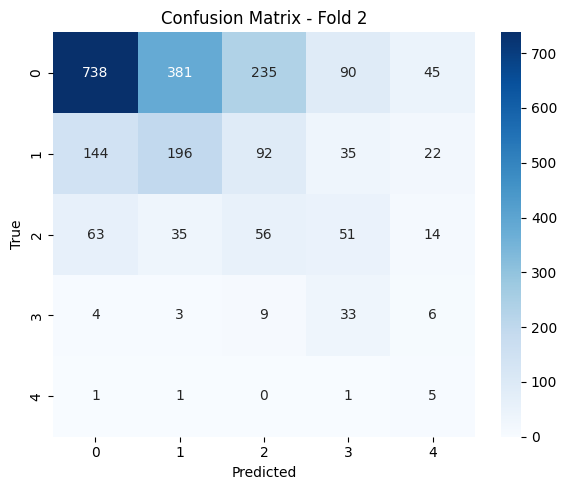

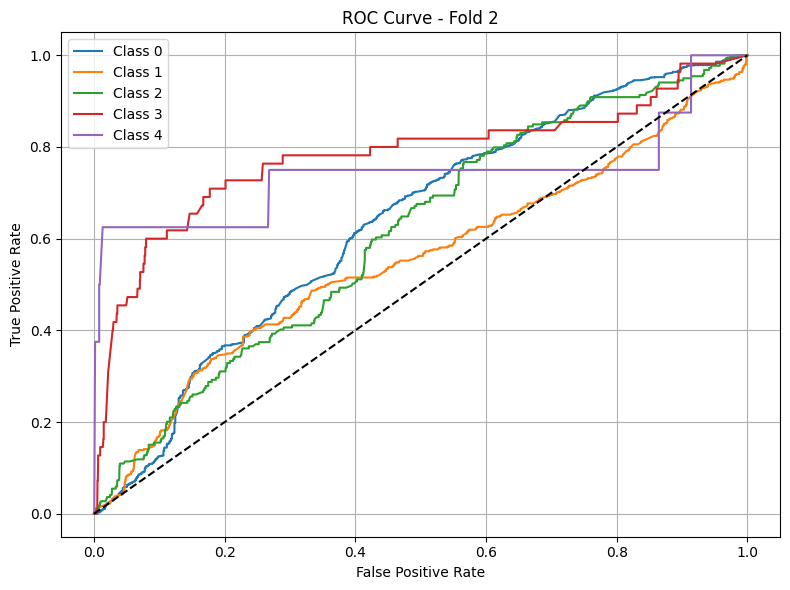


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.52      0.61      1489
           1       0.31      0.32      0.32       489
           2       0.21      0.40      0.27       219
           3       0.13      0.50      0.20        54
           4       0.05      0.62      0.09         8

    accuracy                           0.46      2259
   macro avg       0.29      0.47      0.30      2259
weighted avg       0.59      0.46      0.51      2259



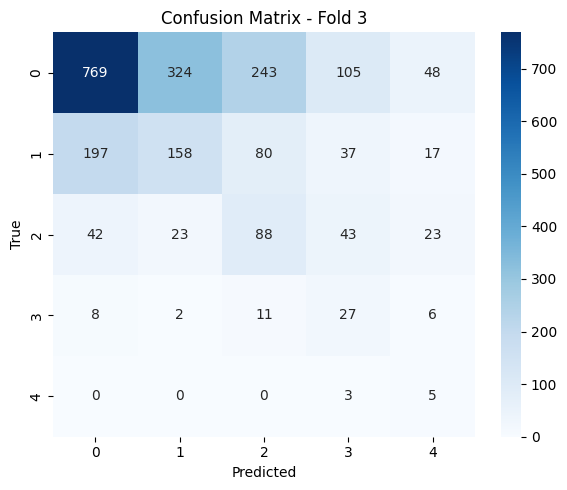

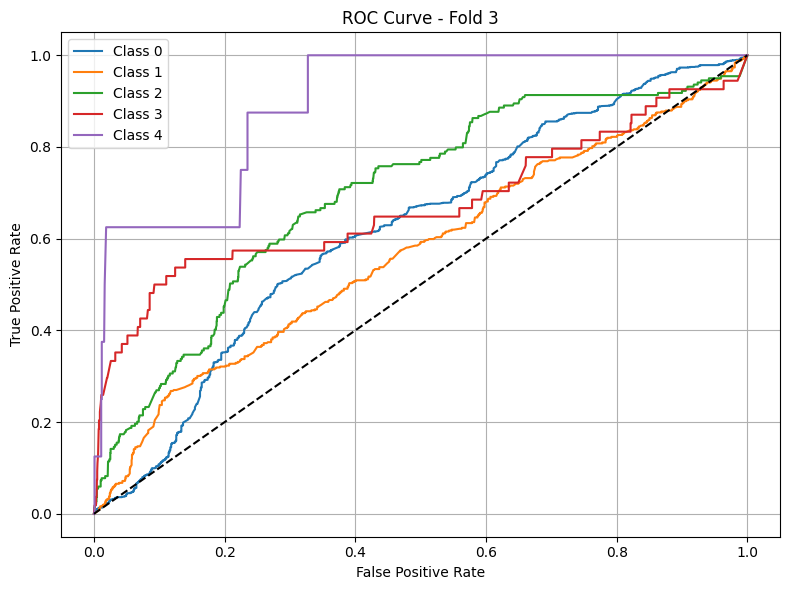


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.43      0.55      1489
           1       0.32      0.42      0.36       489
           2       0.15      0.32      0.21       219
           3       0.17      0.76      0.28        54
           4       0.02      0.12      0.03         8

    accuracy                           0.42      2259
   macro avg       0.28      0.41      0.29      2259
weighted avg       0.59      0.42      0.47      2259



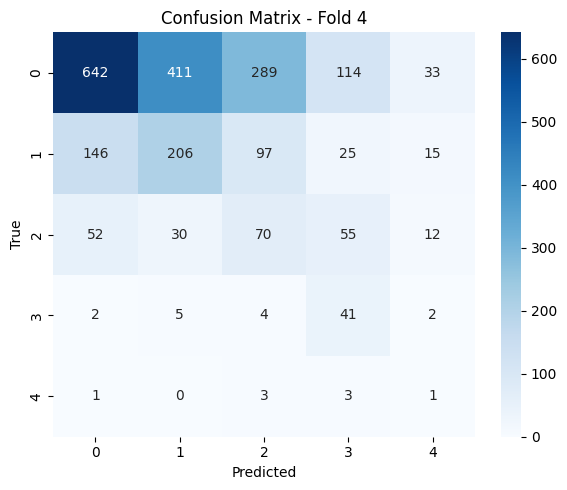

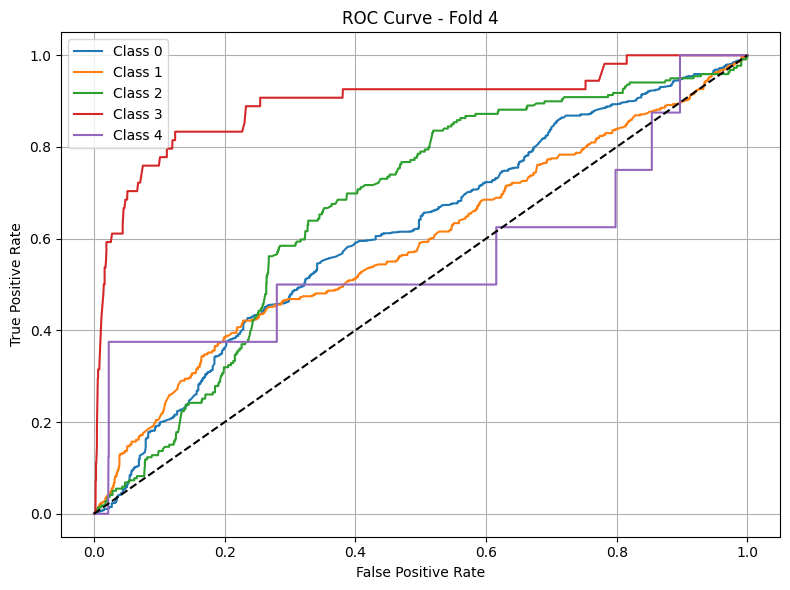


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.40      0.53      1490
           1       0.29      0.44      0.35       488
           2       0.18      0.37      0.25       219
           3       0.14      0.54      0.23        54
           4       0.05      0.62      0.09         8

    accuracy                           0.41      2259
   macro avg       0.29      0.48      0.29      2259
weighted avg       0.61      0.41      0.46      2259



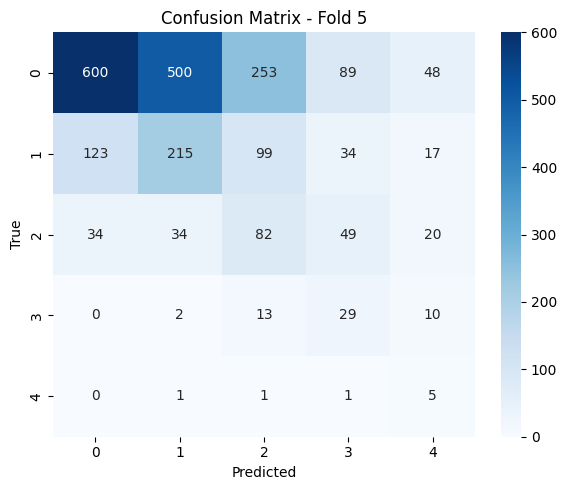

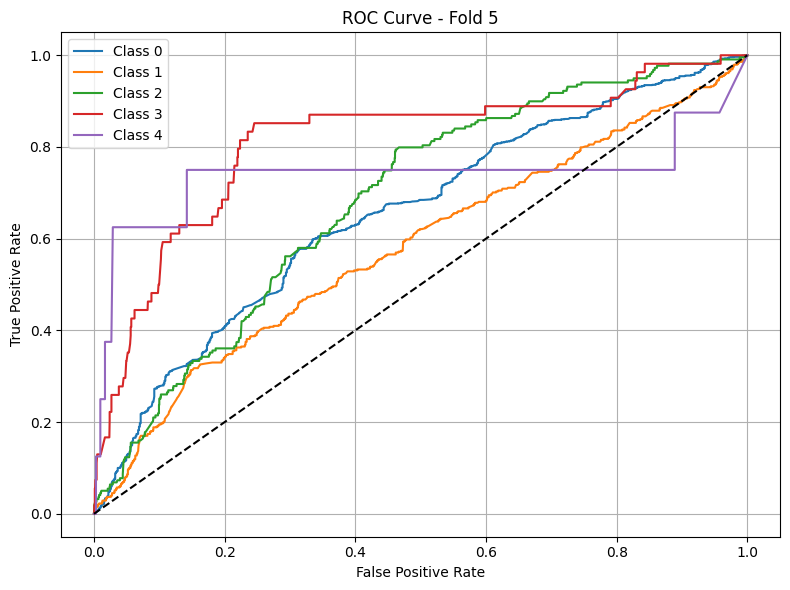


Average Accuracy: 0.4386
Average F1 Macro: 0.2914
Average AUC: 0.6773
{'phase1': [{'fold': 1, 'accuracy': 0.47108655616942907, 'f1_macro': 0.28452678785381236, 'auc': 0.6573029871503392}, {'fold': 2, 'accuracy': 0.4170965364775239, 'f1_macro': 0.27594565901842805, 'auc': 0.6714548053961716}, {'fold': 3, 'accuracy': 0.3747236551215917, 'f1_macro': 0.2631892862417986, 'auc': 0.7088493780102354}, {'fold': 4, 'accuracy': 0.4097273397199705, 'f1_macro': 0.2701543404992693, 'auc': 0.7132880151629672}, {'fold': 5, 'accuracy': 0.43809874723655123, 'f1_macro': 0.27664628841734806, 'auc': 0.6964477490851373}], 'phase2': [{'fold': 1, 'accuracy': 0.4376106194690266, 'f1_macro': 0.2839603572623728, 'auc': 0.6737853593159644}, {'fold': 2, 'accuracy': 0.45486725663716815, 'f1_macro': 0.2984559684604604, 'auc': 0.6633409517286356}, {'fold': 3, 'accuracy': 0.4634794156706507, 'f1_macro': 0.30000271067635664, 'auc': 0.6911754119916861}, {'fold': 4, 'accuracy': 0.4249667994687915, 'f1_macro': 0.28519132

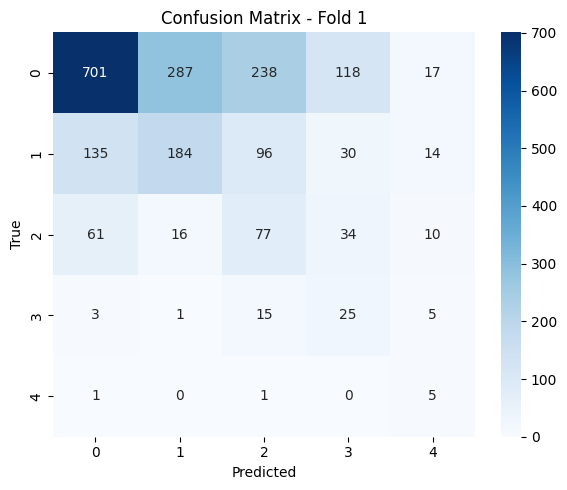

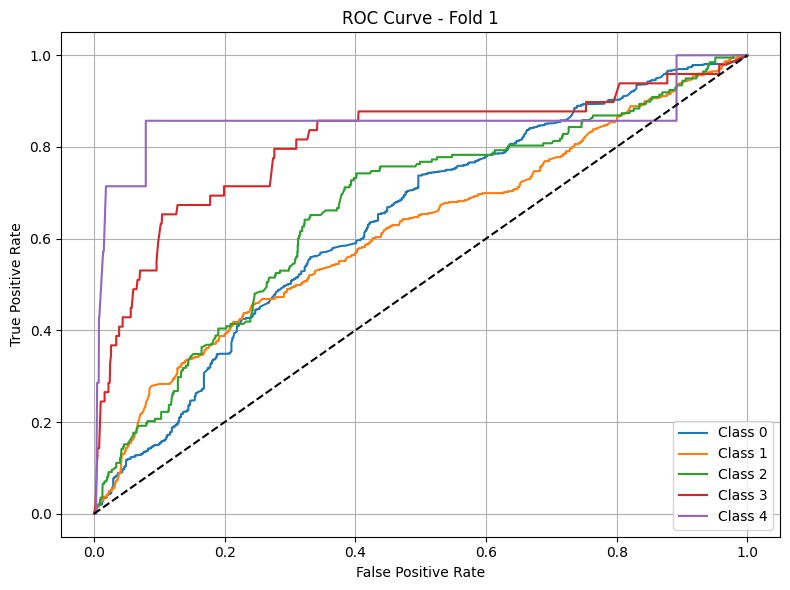


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.50      0.61      1360
           1       0.35      0.41      0.38       459
           2       0.19      0.33      0.24       198
           3       0.16      0.64      0.26        50
           4       0.02      0.29      0.04         7

    accuracy                           0.47      2074
   macro avg       0.30      0.43      0.30      2074
weighted avg       0.60      0.47      0.51      2074



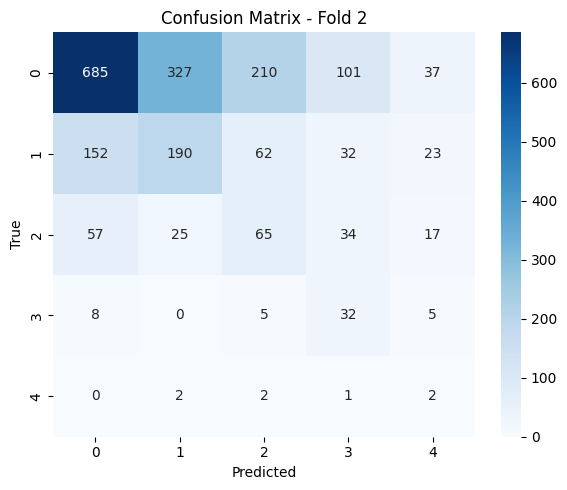

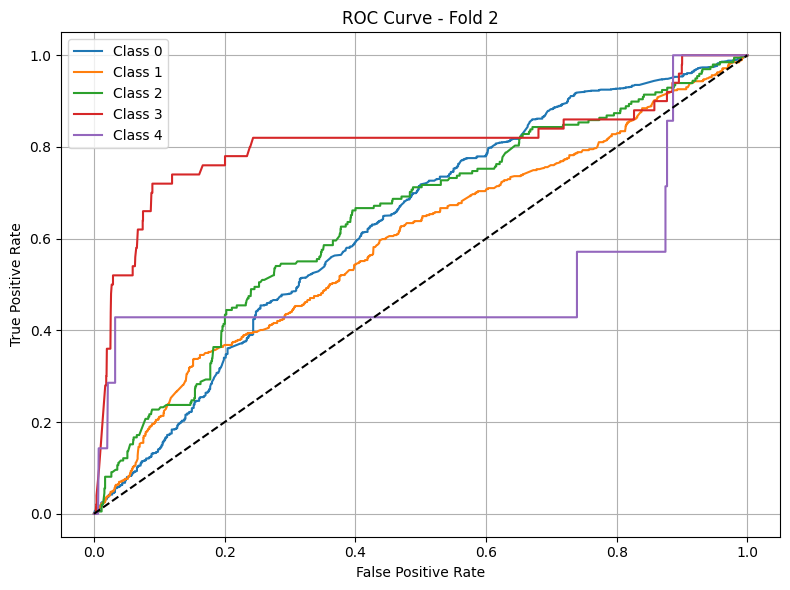


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.49      0.60      1360
           1       0.33      0.41      0.36       459
           2       0.20      0.38      0.26       198
           3       0.14      0.54      0.22        50
           4       0.04      0.43      0.07         7

    accuracy                           0.46      2074
   macro avg       0.30      0.45      0.30      2074
weighted avg       0.60      0.46      0.50      2074



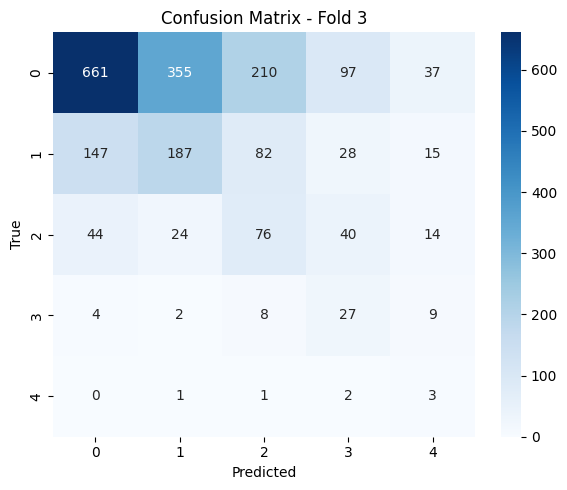

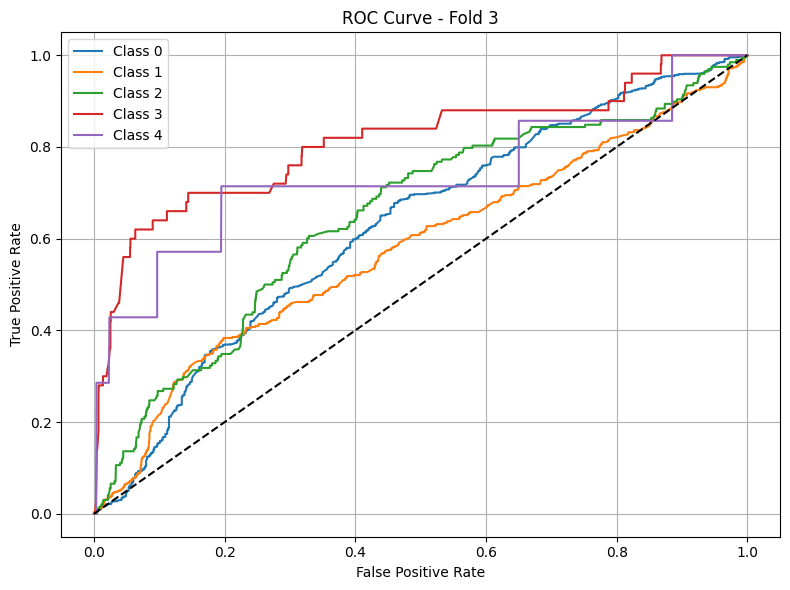


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.49      0.60      1360
           1       0.31      0.39      0.35       459
           2       0.19      0.33      0.24       198
           3       0.15      0.62      0.24        50
           4       0.05      0.71      0.10         7

    accuracy                           0.46      2074
   macro avg       0.30      0.51      0.31      2074
weighted avg       0.60      0.46      0.50      2074



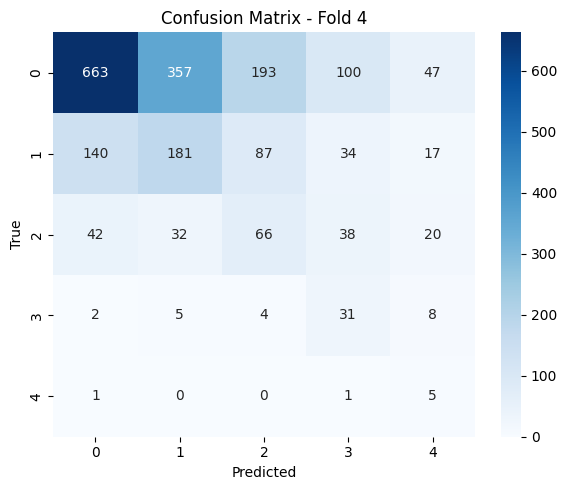

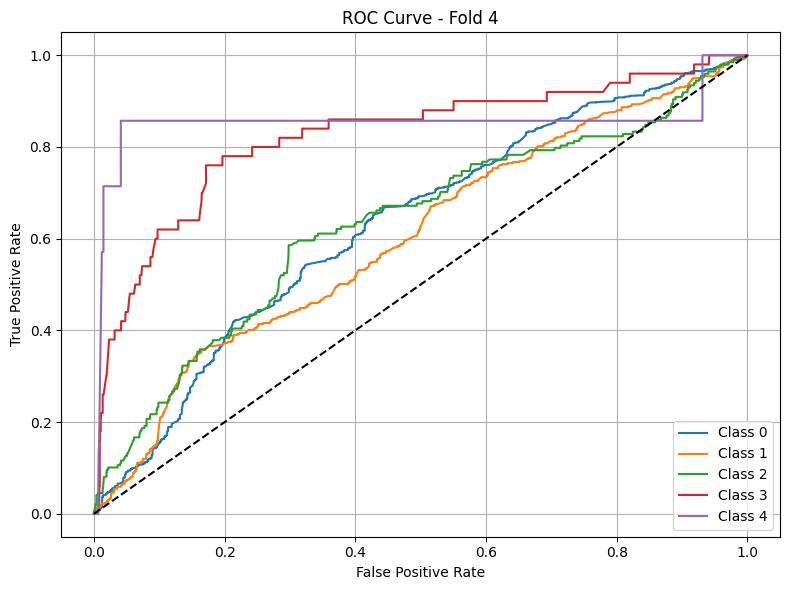


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.41      0.53      1360
           1       0.28      0.39      0.33       460
           2       0.18      0.45      0.26       197
           3       0.11      0.37      0.17        49
           4       0.04      0.29      0.07         7

    accuracy                           0.41      2073
   macro avg       0.27      0.38      0.27      2073
weighted avg       0.58      0.41      0.45      2073



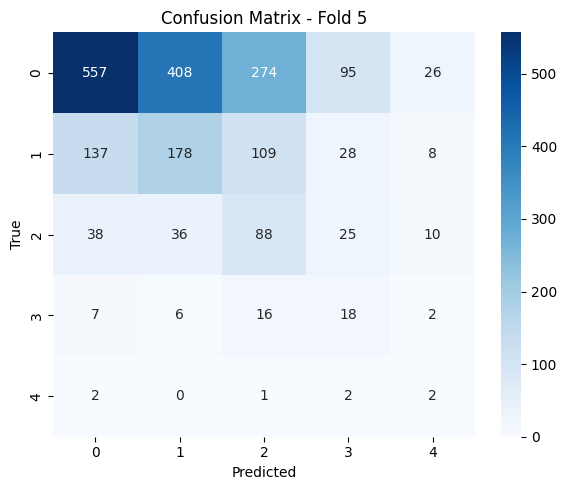

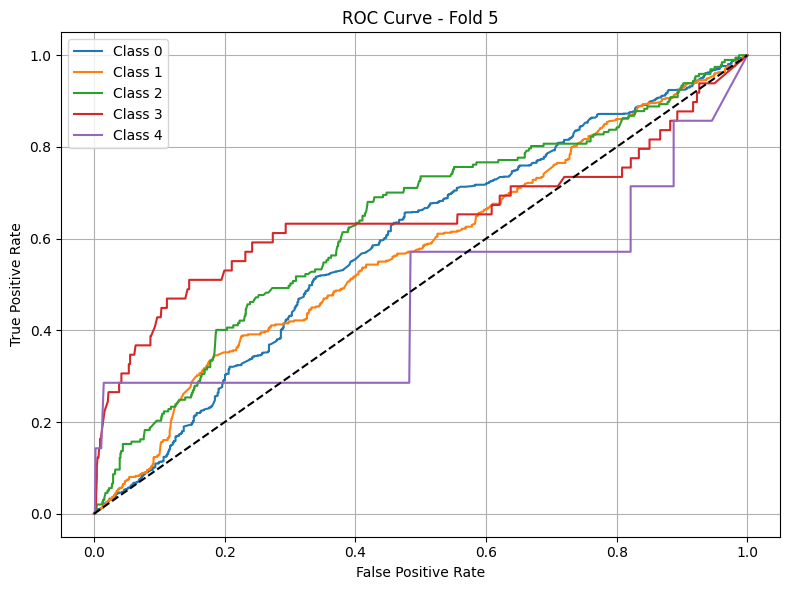


Average Accuracy: 0.4541
Average F1 Macro: 0.3019
Average AUC: 0.6651
{'phase1': [{'fold': 1, 'accuracy': 0.47108655616942907, 'f1_macro': 0.28452678785381236, 'auc': 0.6573029871503392}, {'fold': 2, 'accuracy': 0.4170965364775239, 'f1_macro': 0.27594565901842805, 'auc': 0.6714548053961716}, {'fold': 3, 'accuracy': 0.3747236551215917, 'f1_macro': 0.2631892862417986, 'auc': 0.7088493780102354}, {'fold': 4, 'accuracy': 0.4097273397199705, 'f1_macro': 0.2701543404992693, 'auc': 0.7132880151629672}, {'fold': 5, 'accuracy': 0.43809874723655123, 'f1_macro': 0.27664628841734806, 'auc': 0.6964477490851373}], 'phase2': [{'fold': 1, 'accuracy': 0.4376106194690266, 'f1_macro': 0.2839603572623728, 'auc': 0.6737853593159644}, {'fold': 2, 'accuracy': 0.45486725663716815, 'f1_macro': 0.2984559684604604, 'auc': 0.6633409517286356}, {'fold': 3, 'accuracy': 0.4634794156706507, 'f1_macro': 0.30000271067635664, 'auc': 0.6911754119916861}, {'fold': 4, 'accuracy': 0.4249667994687915, 'f1_macro': 0.28519132

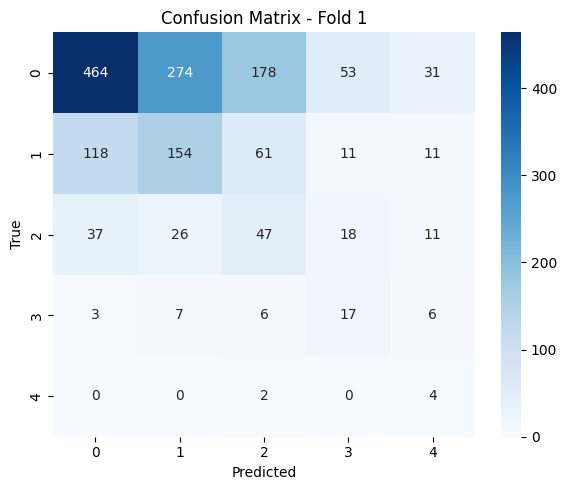

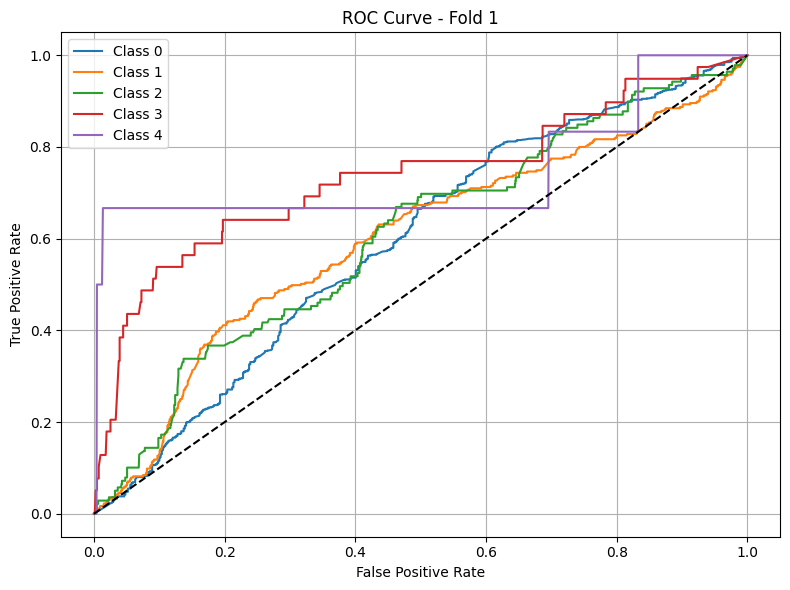


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.49      0.58      1000
           1       0.38      0.37      0.37       355
           2       0.13      0.29      0.19       139
           3       0.15      0.57      0.24        40
           4       0.03      0.40      0.06         5

    accuracy                           0.44      1539
   macro avg       0.28      0.42      0.29      1539
weighted avg       0.57      0.44      0.49      1539



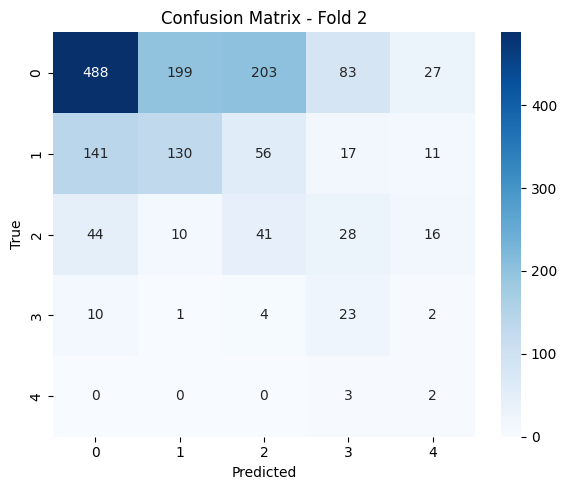

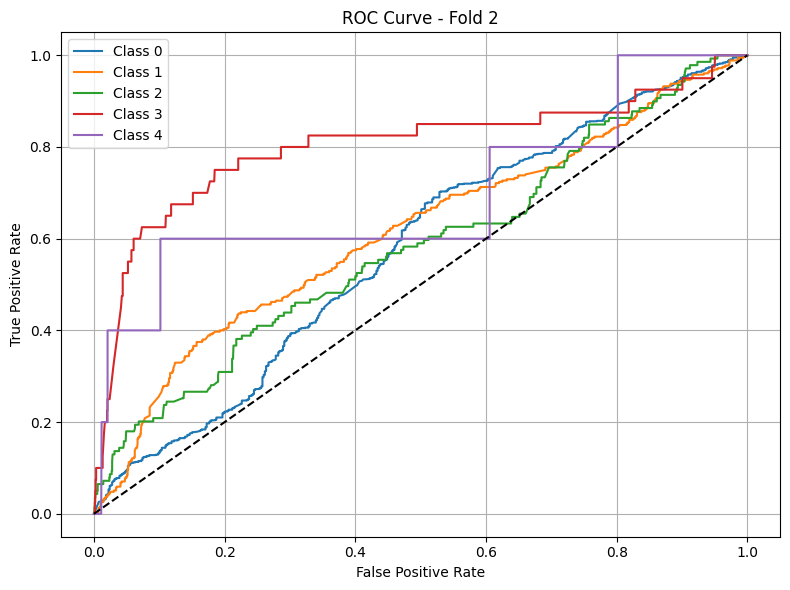


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.52      0.61       999
           1       0.39      0.45      0.42       355
           2       0.17      0.28      0.21       139
           3       0.10      0.42      0.16        40
           4       0.10      0.50      0.16         6

    accuracy                           0.48      1539
   macro avg       0.30      0.44      0.31      1539
weighted avg       0.59      0.48      0.52      1539



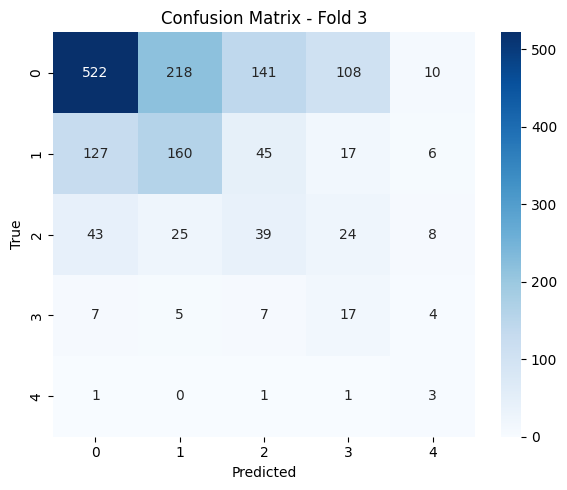

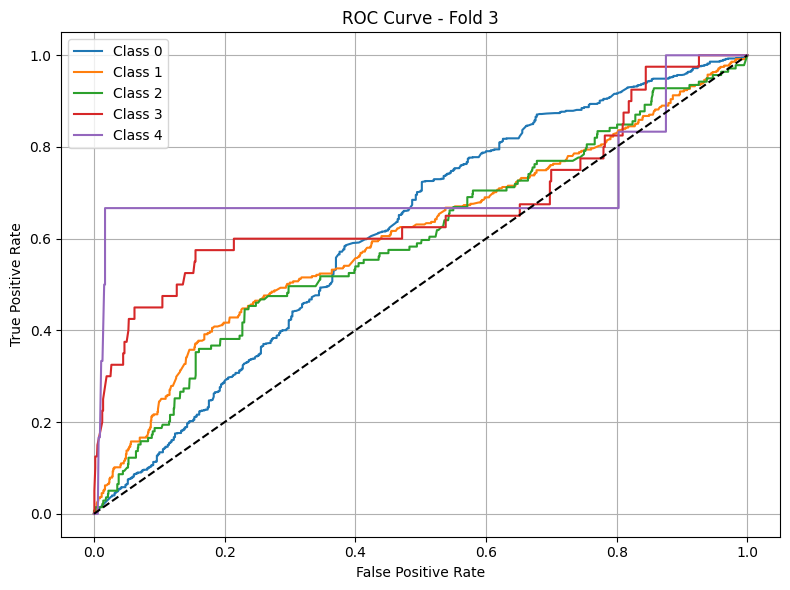


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.48      0.58       999
           1       0.37      0.34      0.35       356
           2       0.12      0.29      0.17       138
           3       0.16      0.62      0.25        39
           4       0.04      0.67      0.08         6

    accuracy                           0.43      1538
   macro avg       0.29      0.48      0.29      1538
weighted avg       0.59      0.43      0.48      1538



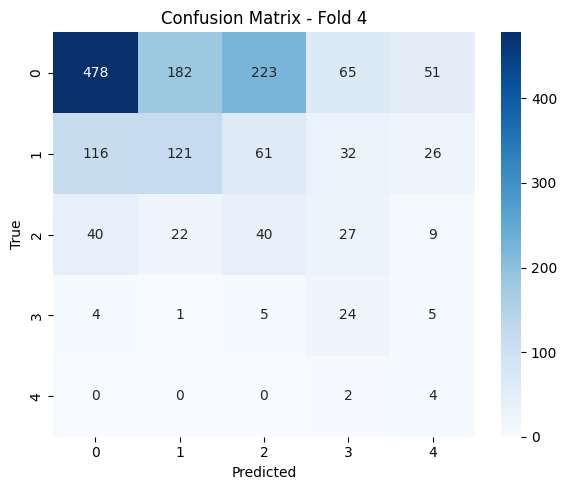

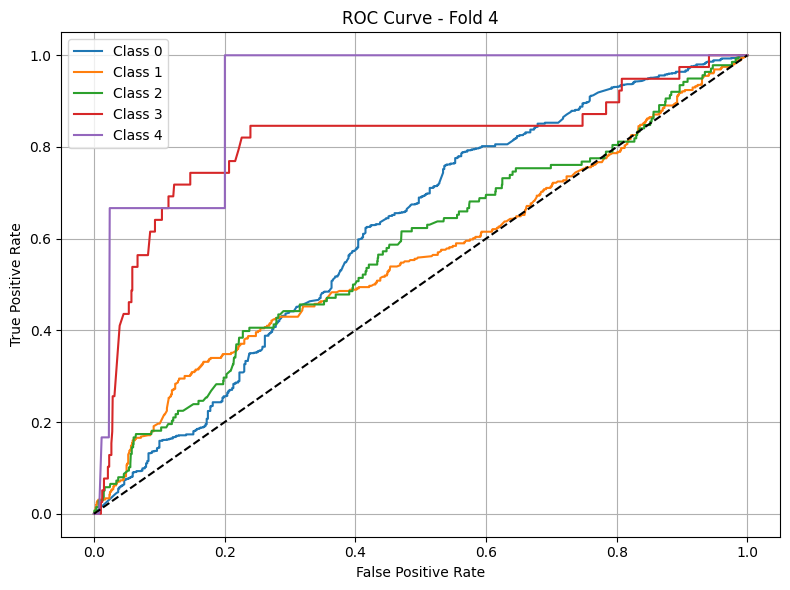


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.51      0.61       999
           1       0.37      0.48      0.42       356
           2       0.15      0.25      0.19       138
           3       0.21      0.69      0.33        39
           4       0.02      0.17      0.04         6

    accuracy                           0.48      1538
   macro avg       0.30      0.42      0.32      1538
weighted avg       0.60      0.48      0.52      1538



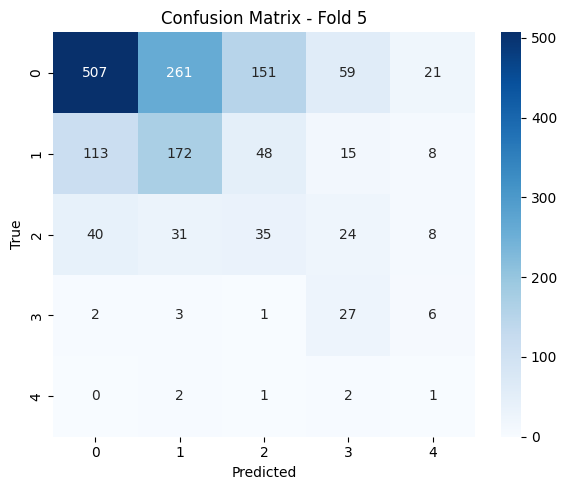

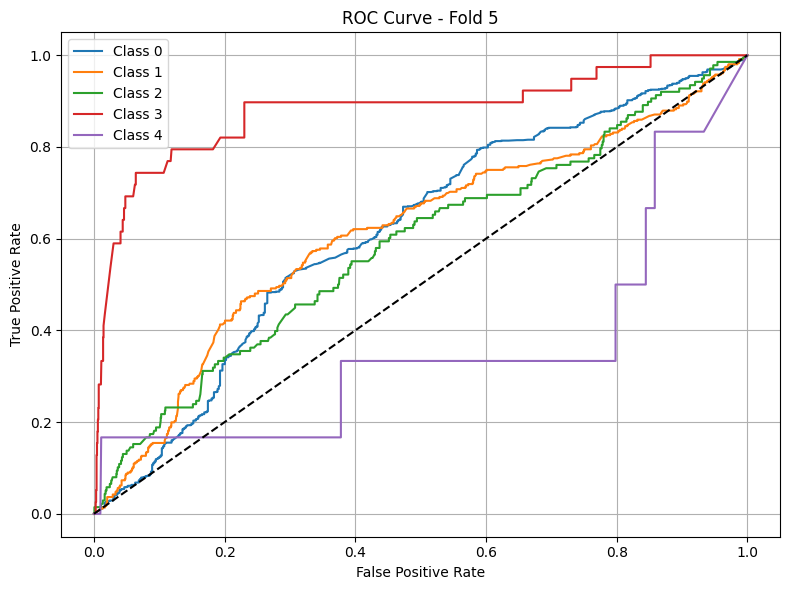


Average Accuracy: 0.4576
Average F1 Macro: 0.3025
Average AUC: 0.6510
{'phase1': [{'fold': 1, 'accuracy': 0.47108655616942907, 'f1_macro': 0.28452678785381236, 'auc': 0.6573029871503392}, {'fold': 2, 'accuracy': 0.4170965364775239, 'f1_macro': 0.27594565901842805, 'auc': 0.6714548053961716}, {'fold': 3, 'accuracy': 0.3747236551215917, 'f1_macro': 0.2631892862417986, 'auc': 0.7088493780102354}, {'fold': 4, 'accuracy': 0.4097273397199705, 'f1_macro': 0.2701543404992693, 'auc': 0.7132880151629672}, {'fold': 5, 'accuracy': 0.43809874723655123, 'f1_macro': 0.27664628841734806, 'auc': 0.6964477490851373}], 'phase2': [{'fold': 1, 'accuracy': 0.4376106194690266, 'f1_macro': 0.2839603572623728, 'auc': 0.6737853593159644}, {'fold': 2, 'accuracy': 0.45486725663716815, 'f1_macro': 0.2984559684604604, 'auc': 0.6633409517286356}, {'fold': 3, 'accuracy': 0.4634794156706507, 'f1_macro': 0.30000271067635664, 'auc': 0.6911754119916861}, {'fold': 4, 'accuracy': 0.4249667994687915, 'f1_macro': 0.28519132

In [9]:
import torch

phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")

    sample = True
    
    # Save best model state_dict and scaler
    sample_tag = "sample" if sample else "no_sample"
    best_model_state, best_scaler, best_label_encoder, metrics = train_phase(phase_path, sample=sample)
    torch.save(best_model_state, f"best_model_state_{sample_tag}_phase{i}.pt")
    joblib.dump(best_scaler, f"best_scaler_{sample_tag}_phase{i}.pkl")
    joblib.dump(best_label_encoder, f"label_encoder_{sample_tag}_phase{i}.pkl")
    
    results[f"phase{i}"] = metrics
    print(results)


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.70      0.79       568
           1       0.12      0.27      0.17        63
           2       0.19      0.35      0.24        43
           3       0.09      0.13      0.11        15
           4       0.00      0.00      0.00         9

    accuracy                           0.62       698
   macro avg       0.26      0.29      0.26       698
weighted avg       0.75      0.62      0.67       698



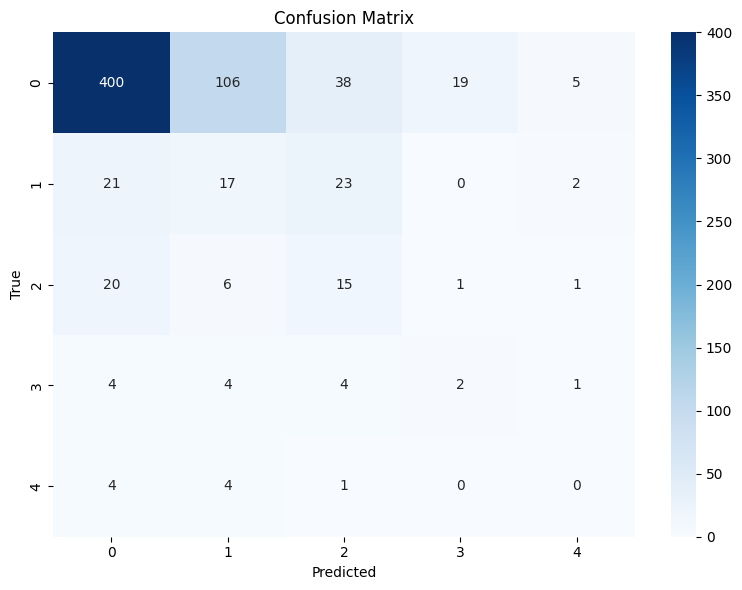


Test AUC (macro-average, OVR): 0.5688


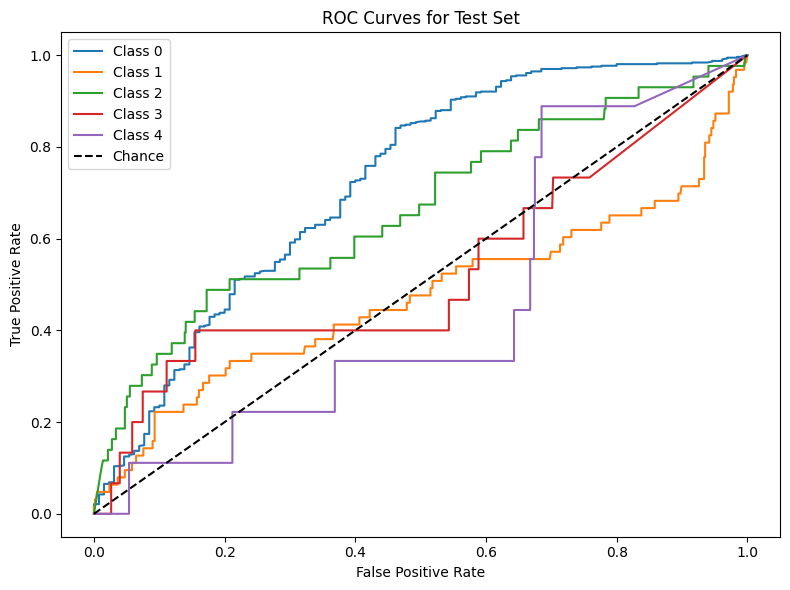


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.56      0.69       544
           1       0.12      0.54      0.19        59
           2       0.14      0.17      0.15        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.52       668
   macro avg       0.23      0.25      0.21       668
weighted avg       0.75      0.52      0.59       668



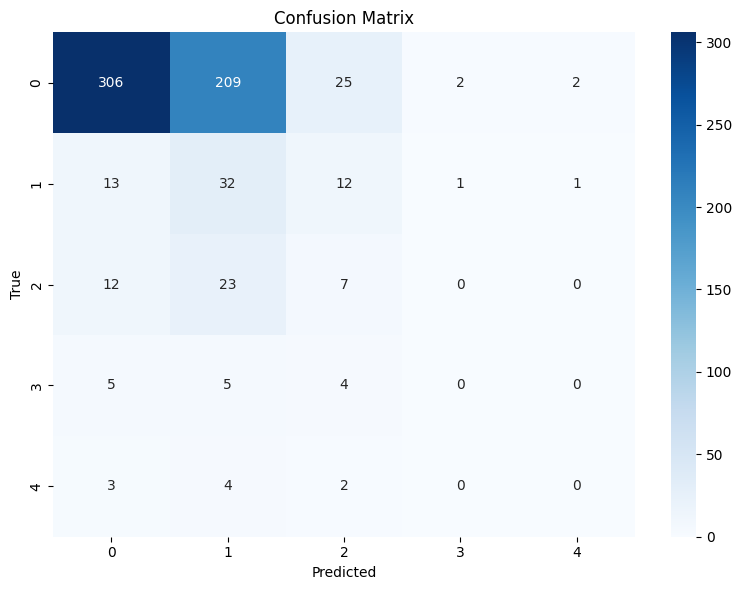


Test AUC (macro-average, OVR): 0.5068


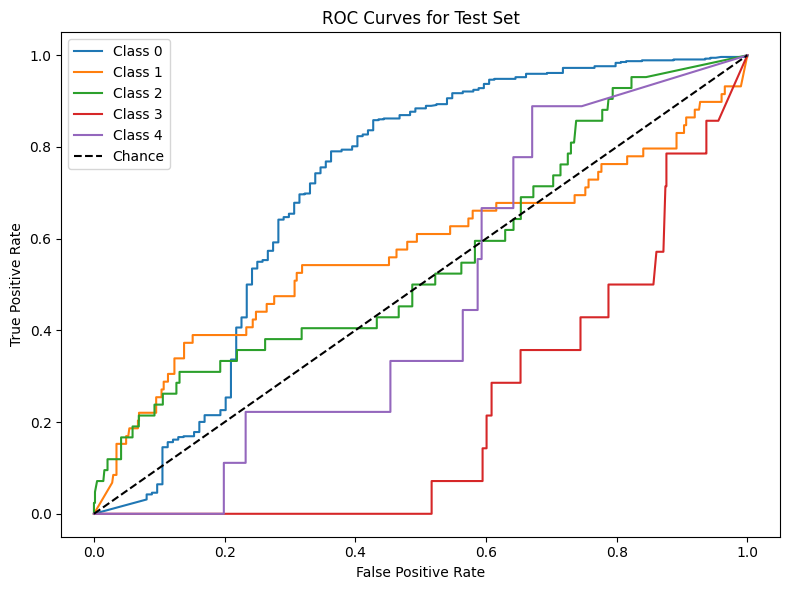


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.68      0.76       455
           1       0.07      0.17      0.10        52
           2       0.17      0.28      0.21        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.59       554
   macro avg       0.22      0.23      0.21       554
weighted avg       0.73      0.59      0.64       554



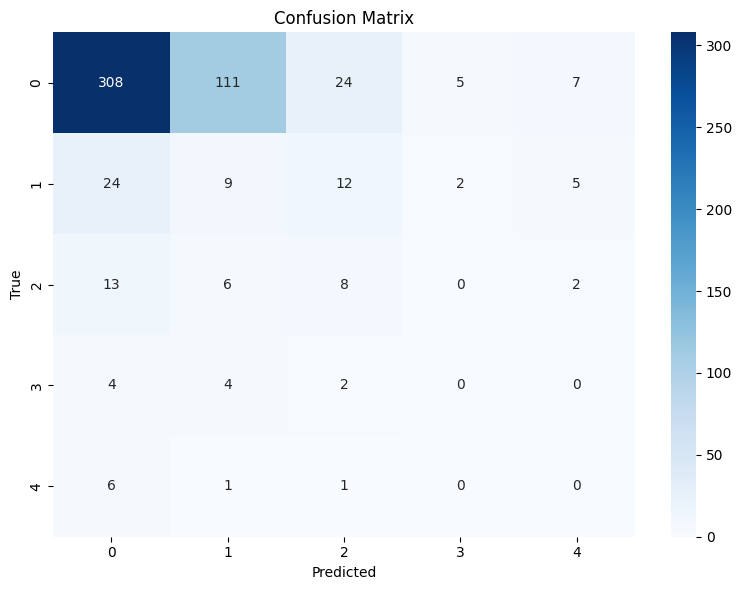


Test AUC (macro-average, OVR): 0.5178


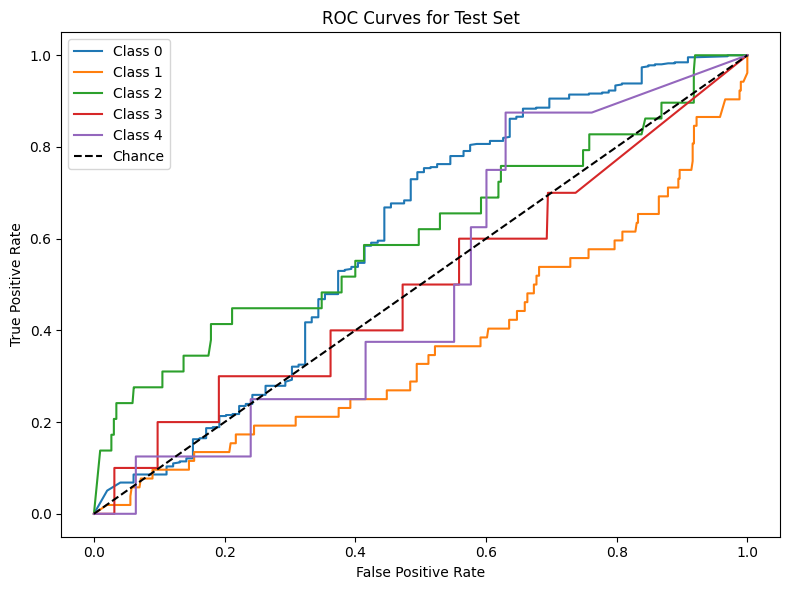


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.51      0.65       395
           1       0.15      0.33      0.20        40
           2       0.05      0.29      0.08        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.47       477
   macro avg       0.21      0.23      0.19       477
weighted avg       0.73      0.47      0.56       477



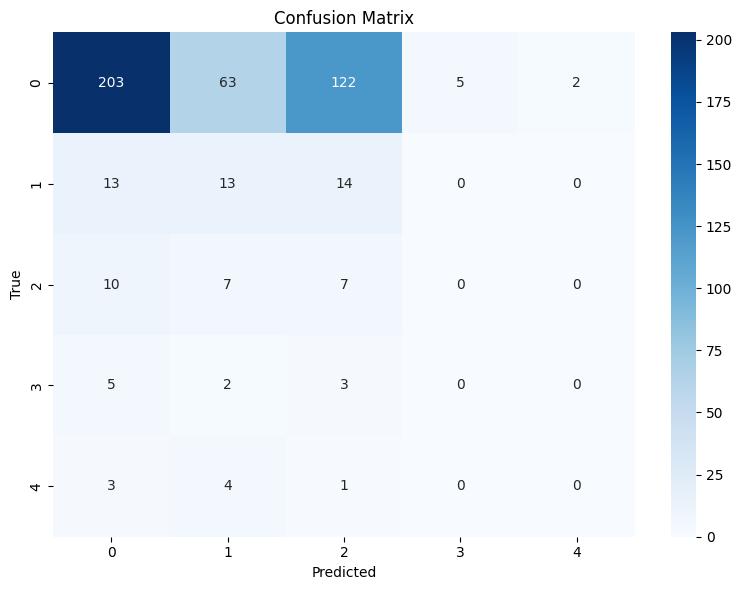


Test AUC (macro-average, OVR): 0.4728


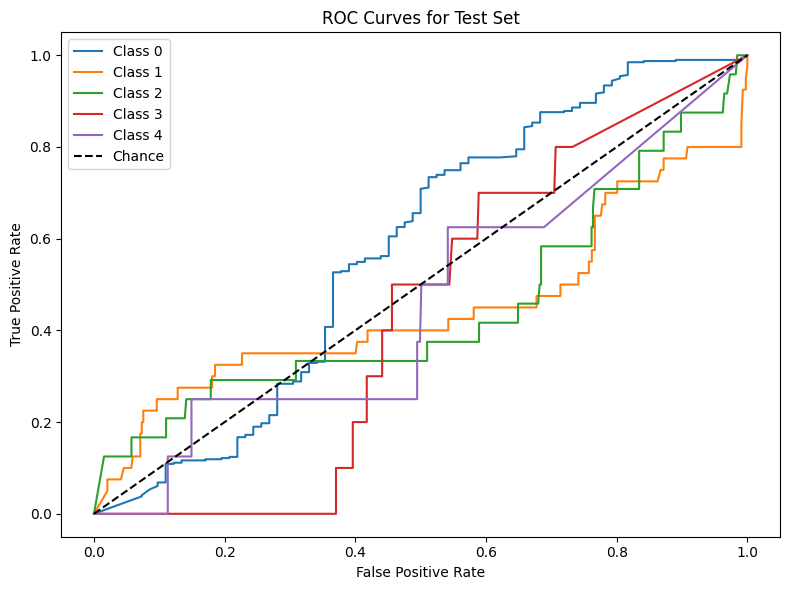

In [10]:
for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_state_{sample_tag}_phase{i}.pt'
    scaler_path = f'/kaggle/working/best_scaler_{sample_tag}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'
    
    label_encoder_dir = f"/kaggle/working/label_encoder_{sample_tag}_phase{i}.pkl"

    # Predict on test set
    y_preds = evaluate_gnn_on_test(
        test_file_path = test_dir,
        model_class=GATModel,
        model_state_dict=model_path,
        scaler_file=scaler_path,
        label_encoder_file = label_encoder_dir,
        school_mapping_file=school_mapping_file,
        k=5
    )